In [1]:
from collections import defaultdict

## see examples in https://www.gurobi.com/resource/modeling-examples-using-the-gurobi-python-api-in-jupyter-notebook/
import gurobipy as gp
from gurobipy import GRB

import math
import numpy as np
import sys

from fruit_distribution import *   # import module to create the various desired fruit distributions 
from IG_data_analysis import *     # import module to analyze the data from the snapshots

# tested with Python 3.7.0 & Gurobi 9.0

## based on the Gurobi technician routing scheduling example
# https://gurobi.github.io/modeling-examples/technician_routing_scheduling/technician_routing_scheduling.html

In [2]:
## Functions
def getRNGSeedList(n_runs):
        '''
           Open the random seed list rngseed_list_20200901.csv with 200 seeds for each of the 3 real fruit coordinate axis
           and 3 fake fruit coordinate axis.
        '''
        # keeps track of the row number of the csv being read (each row contains the seeds for one run)
        csv_i     = 0

        seed_list = list()

        with open('./rngseed_list_20200901.csv') as csvfile:
            reader = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
            for row in reader:
                seed_list.append(row)
                if csv_i == n_runs:
                    break

                csv_i += 1

        # print(seed_list)
        return(seed_list)
    
    
def createFruit(fruitD, set_algorithm, set_distribution, density, x_seed, y_seed, z_seed):
        if set_distribution == 0:
            csv_file = './TREE_FRUIT_DATA/apple_tree_data_2015/Applestotheright.csv'
            [numFruit, sortedFruit] = fruitD.csvFile(csv_file, 0)

        elif set_distribution == 1:
            if set_algorithm == 1:
                [numFruit, sortedFruit] = fruitD.uniformRandomMelon(density, y_seed, z_seed)
            else:
                [numFruit, sortedFruit] = fruitD.uniformRandom(density, x_seed, y_seed, z_seed)
            # print()
            # print('--------------------------------------------')
            # print('Number of fruit:', numFruit)
            # print()

        elif set_distribution == 2: 
            fruit_in_cell = math.ceil(density * (cell_h*cell_l*arm_reach)) # num of fruit in front of cell if using (equalCellDensity())
            print('Number of fruit in each cell:', fruit_in_cell)
            print()
            [numFruit, sortedFruit] = fruitD.equalCellDensity(n_row, n_arm, cell_h, cell_l, arm_reach, fruit_in_cell, x_seed, y_seed, z_seed)

        elif set_distribution == 3: 
            densities = np.array([5, 4, 3])
            [numFruit, sortedFruit] = fruitD.uniformRandomMelon_MultipleDensity(densities, y_seed, z_seed)

        elif set_distribution == 4: 
            [numFruit, sortedFruit] = fruitD.column(v_vy, v_max, a_max, t_grab, n_row, n_arm, cell_h, z_seed)
            
        elif set_distribution == 5:
            z_coord = cell_h / 2
            [numFruit, sortedFruit] = fruitD.column_melon(n_fruit, d_y, z_coord)

        else: 
            print('not a correct fruit distribution, defaulting to uniform random')
            if set_algorithm == 1:
                [numFruit, sortedFruit] = fruitD.uniformRandomMelon(density, y_seed, z_seed)
            else:
                [numFruit, sortedFruit] = fruitD.uniformRandom(density, x_seed, y_seed, z_seed)

        return([numFruit, sortedFruit])
    
    
def calc_TW(arm_n, y_coord, v_vy):
    TW_start = (y_coord + (arm_n - 1)*l) / v_vy
    TW_end   = (y_coord + arm_n*l) / v_vy
    return([TW_start, TW_end])


def getHorizonIndex(sortedFruit, q_vy, vehicle_l, horizon_l):
    '''
    Saves this snapshot's horizon fruit indexes based on the sortedFruit indexes to 
    compare and remove picked fruit.
    '''
    # edges of the horizon based on vehicle location and length
    horizon_back  = q_vy + vehicle_l
    horizon_front = horizon_back + horizon_l

    H_fruit_index = np.where((sortedFruit[1,:] >= horizon_back) & (sortedFruit[1,:] < horizon_front))

    return(H_fruit_index[0])


def calcDensity(q_vy, v_vy, n_row, n_arm, cell_l, cell_h, arm_reach, sortedFruit):
    '''Get the fruit density, d, of each cell'''
    ## should the columns be based on cell length? number of arms? 
    #  should the columns be the same width? increase/decrease the closer to the front of vehicle?
    #  should I calculate R per horizontal row of arms?

    d = np.zeros([n_row, n_arm])  # total number of cells
    # starting position on the z-axis (up-down on robot)
    row_z = 0.

    for n in range(n_row):
        # starting position in the y_axis (front-back on robot)
        col_y = q_vy

        for k in range(n_arm):
            # print('col', n, 'row', k)
            # print('back', col_y, 'front', col_y + cell_l)
            # print('bottom', row_z, 'top', row_z + cell_h)
            index = np.where((sortedFruit[1,:] >= col_y) & (sortedFruit[1,:] < col_y + cell_l) & 
                        (sortedFruit[2,:] >= row_z) & (sortedFruit[2,:] < row_z + cell_h) & 
                        (sortedFruit[4,:] < 1))
            # save the number of fruit in this cell
            d[n,k] = len(index[0])
            # print(d)
            # move to the next column of cells
            col_y += cell_l

        # move up to the next cell on this column
        row_z += cell_h

    # before calculating the true density, check total number of fruit
    # print('which sums to', np.sum(d))   # has to be equal to numer of fruit
    # divide all the values by the volume of space in front of each cell 
    d = d / (arm_reach * cell_l * cell_h)

    # print('fruit density in each cell [fruit/m^3]:')
    # print(d)

    return(d)


def calcR(v_vy, fruit_in_horizon, horizon_l, vehicle_h, arm_reach):
    '''Calculate the R value given a speed and horizon volume and density'''
    try:
        density_H = fruit_in_horizon / (horizon_l * vehicle_h * arm_reach)
        time_H    = horizon_l / v_vy

        R         = density_H / time_H # in fruit / (m^3 * s)

    except ZeroDivisionError:
        R         = 0 

    # print('Fruit incoming rate based on the horizon [fruit/(m^3 s)]:')
    # print(R)
    return(R) 

def calcStateTime(fruit_picked_by, travel_l, v_vy, total_arms, n_row, n_arm, Td):
    # def calculateStateTimePercent(self, fruit_picked_by, total_distance):
        '''Calculates the time each arm is in each state so that it can plotState can plot the data'''
        # total_distance = self.y_lim[1] - self.y_lim[0]
        total_distance = travel_l
        total_time = total_distance / v_vy  # for snapshots? -> I'm deleting Tm and Tw data at each snapshot, problem
#         print('movement distance:', total_distance)
#         print('total move time:', total_time)

        ## states: idle, pick_yz, pick_x, grab, retract_x, move_z/unload
        # self.state_percent = np.zeros([self.total_arms, 6]) # save each arm's percent time in each of the six states 
        state_time = np.zeros([total_arms, 7]) # save each arm's percent time in each of the six states plus a total

        for n in range(n_row):
            for k in range(n_arm):
                tot_arm_index = k + (n*n_arm)
                # # calculate arm's move_yz using Tm
                # for tm in self.Tm_values[n][k]:
                #     self.state_time[tot_arm_index,1] += tm

                if n_row > 1:
                    num_picked = len(fruit_picked_by[n][k])
#                     print('arm', k, 'picked', num_picked, 'fruit, from', fruit_picked_by[n][k])
                else:
                    num_picked = len(fruit_picked_by[k])
#                     print('arm', k, 'picked', num_picked, 'fruit, from', fruit_picked_by[k])
                    
                busy = num_picked * Td
#                 print('so was busy', busy, 'total seconds')
#                 print()
                state_time[tot_arm_index,1] = busy  # setting Tm as the "handling time"

                # calculate idle by subtracting all before by total time: length_row / v
                state_time[tot_arm_index,0] = total_time - np.sum(state_time[tot_arm_index,:])
                # save the total time for this run to get total percent later
                state_time[tot_arm_index,6] = total_time
                
        return(state_time)

In [3]:
## Constants 
## to print out from data analysis
print_out  = 1
plot_out   = 1

## settings
Td         = 2.      # fruit handling time
M          = 80     # arbitrarily large number, set 600 from paper
# v_vy_fruit = 0.3     # in m/s, assumed vehicle velocity along orchard row to build line distribution
v_vy_fruit_cmps = 30
q_vy       = 0.      # in m, backmost, lowest coordinate of the vehicle

v_max      = 0.5
a_max      = 1.
t_grab     = 0.1 

n_row      = 1       # total number of horizontal rows with cells containg one arm per cell
n_arm      = 2       # number of arms in one horizontal row

density    = 2       # in fruit/m^2, makespan is being limited to rho = 2 with random placement
n_fruit    = 80      # in fruit, for melon column distribution

FPE_min    = 0.95

noRel_time_ub  = 1000   # no relaxation heuristic max time to solve before moving to branch and bound (varies)
timLim_time_ub = 3600*15
v_vy_ub_cmps   = 90    ##### TEST THIS ONE #####

l          = 0.3     # in m, length of the cell along the orchard row (y-axis), parallel to vehicle travel
w          = 2.      # in m, width/height of the horizontal row of arms (z-axis) perpendicular to vehicle travel

cell_l     = l
cell_h     = w
arm_reach  = 1.

vehicle_l  = n_arm * cell_l
vehicle_h  = n_row * cell_h

## for future addition of snapshots
horizon_l  = 0.

## set fruit distribution flag
# 0     == Raj's digitized fruits
# 1     == uniform random  (if algorithm == 1, use melon version)
# 2     == uniform random, equal cell density
# 3     == multiple densities separated by some space (only melon for now)
# 4     == fruit in vertical columns
# 5     == "melon" version of columns (user inputs desired no. fruits, z height, and distance between fruit in y-coord)
set_distribution = 5

## set algorithm being used 
# 1     == melon
# not 1 == not melon
set_algorithm    = 1

## set MIP model settings
# 0     == basic MIP model from the melon paper
# 1     == basic MIP model with velocity as a variable
set_MIPsettings  = 1

n_snapshots = 1 # for now a constant


In [4]:
## Get fruit list based on desired distribution
n_runs = 1

seed_list = getRNGSeedList(n_runs)

for run in range(n_runs):
    # get seeds for x, y, and z RNG (probably unneccessary right now, especially for x)
    seed = [seed_list[run][0], seed_list[run][1], seed_list[run][2]]
    x_seed = PCG64(int(seed[0]))
    y_seed = PCG64(int(seed[1]))
    z_seed = PCG64(int(seed[2]))
    
if set_distribution == 0:
    travel_l  = 12 + vehicle_l # in m
    density   = 48.167         # in fruit/m^2 (on avg.), constant
    n_runs    = 1

elif set_distribution == 1:
    travel_l  = 5 + vehicle_l # in m

elif set_distribution == 3:
    travel_l  = 30 + vehicle_l # in m
    
elif set_distribution == 5:
    v_vy_fruit_mps = v_vy_fruit_cmps / 100
    d_y  = Td*v_vy_fruit_mps*(n_fruit+1)/(n_fruit+2) # kind of works 3/4 or 5/8 fruit with 1 arm: (Td/2)*v_vy
#     d_y  = Td*v_vy_fruit*(n_fruit+1)/(n_fruit+2) # kind of works 3/4 or 5/8 fruit with 1 arm: (Td/2)*v_vy
    print('with Td', Td, 'and v_vy for fruit distribution', v_vy_fruit_cmps, 'cm/s')
    print('d_y for this line of fruit:', d_y, 'so the total distance they take up:', d_y*n_fruit)
    travel_l  = d_y * n_fruit + vehicle_l # in m

else: 
    travel_l  = 10 + vehicle_l # in m 
    
x_lim   = [0.2, 1.2]
y_lim   = [0. , travel_l - vehicle_l]
z_lim   = [0., 2.] 

fruitD = fruitDistribution(x_lim, y_lim, z_lim)
[numFruit, sortedFruit] = createFruit(fruitD, set_algorithm, set_distribution, density, x_seed, y_seed, z_seed)

print('Total fruit in the orchard row',numFruit)
# print()
# print('List of the x, y, and z coordinates of the sorted fruit')
# print(sortedFruit)

# array to save which arm picked which fruit
curr_j = np.zeros([n_row, n_arm])

with Td 2.0 and v_vy for fruit distribution 30 cm/s
d_y for this line of fruit: 0.5926829268292683 so the total distance they take up: 47.41463414634146
fruit y-coordinates: [ 0.          0.59268293  1.18536585  1.77804878  2.37073171  2.96341463
  3.55609756  4.14878049  4.74146341  5.33414634  5.92682927  6.5195122
  7.11219512  7.70487805  8.29756098  8.8902439   9.48292683 10.07560976
 10.66829268 11.26097561 11.85365854 12.44634146 13.03902439 13.63170732
 14.22439024 14.81707317 15.4097561  16.00243902 16.59512195 17.18780488
 17.7804878  18.37317073 18.96585366 19.55853659 20.15121951 20.74390244
 21.33658537 21.92926829 22.52195122 23.11463415 23.70731707 24.3
 24.89268293 25.48536585 26.07804878 26.67073171 27.26341463 27.85609756
 28.44878049 29.04146341 29.63414634 30.22682927 30.8195122  31.41219512
 32.00487805 32.59756098 33.1902439  33.78292683 34.37560976 34.96829268
 35.56097561 36.15365854 36.74634146 37.33902439 37.93170732 38.52439024
 39.11707317 39.7097561  40.302

In [5]:
class Arm():
    def __init__(self, row_n, arm_n):
        self.row_n = row_n
        self.arm_n = arm_n

    def __str__(self):
        return f"Arm: {self.arm_n}\n Horizontal Row Number: {self.row_n}"

In [6]:
class Fruit():
    def __init__(self, index, y_coord, z_coord):#, job, tStart, tEnd, tDue):
        self.index = index       # fruit's index when ordered by y-coordinate
        self.y_coord = y_coord   # y-coordinate of the fruit
        self.z_coord = z_coord
        
    def __str__(self):
        return f"Fruit Index: {self.index}\n  Y-axis location: {self.y_coord}\n"

In [7]:
class Job_v_vy():
    # for basic MIP with vehicle velocity as a variable
    def __init__(self, fruit_i, arm_k):
        self.fruit_i = fruit_i
        self.arm_k   = arm_k

In [8]:
## create arm object list
arm = list()

for r in range(n_row):
# for r in range(1, n_row+1):
    for k in range(n_arm):
#     for k in range(1, n_arm+1):
        this_arm = Arm(r, k)
        arm.append(this_arm)
    
# print(arm)

In [9]:
## create fruit object list
fruit = list()

for index in range(numFruit):
    y_coord = sortedFruit[1][index]
    z_coord = sortedFruit[2][index]
    this_fruit = Fruit(index, y_coord, z_coord)
#     print('Fruit index', index, 'should match this index', sortedFruit[3][index])
#     print('with y and z coordinates:', y_coord, z_coord)

    fruit.append(this_fruit)

# print(fruit)

In [10]:
## create job oject list
job = list()

for k in arm:
    for i in fruit:  
        this_job = Job_v_vy(i, k)
#         
#         print('for arm', this_job.arm_k.arm_n, 'and fruit', this_job.fruit_i.index)
#         print('TW starts at', this_job.TW_start, 'and TW ends at', this_job.TW_end)
        job.append(this_job)
    
# print(len(job))
# print(len(arm)*len(fruit))

In [11]:
def solve_melon_mip(arm, fruit, job):
    ## Build useful data structures
    # lists:
    K = [k.arm_n for k in arm]      # list of arm numbers
    N = [i.index for i in fruit]    # list of fruit indexes
    Y = [i.y_coord for i in fruit]  # list of fruits' y-coordinate (x-coordinate in the paper)
#     print('number of arms:',K, 'with length', len(K))
#     print()
#     print('number of fruits:',N, 'with length', len(N))
#     print()
#     print('fruit y-coordinate:', Y, 'with length', len(Y))
#     print()

    total_fruit = len(N) # needed to constraint FPE to a high picking percentage

    
    ### Create model
    m = gp.Model("makespan_mip")
    
    
    ### change needed model parameters
    ### see https://www.gurobi.com/documentation/9.5/refman/python_parameter_examples.html#PythonParameterExamples
    # if velocity becomes a variable, it is multiplied with another variable requiring the following settings
    m.params.NonConvex = 2
    m.setParam('NonConvex', 2)
    
    # Due to *very* high complexity, limits time in the no relaxation heuristic
    # see https://www.gurobi.com/documentation/9.5/refman/norelheurtime.html
    m.setParam('NoRelHeurTime', noRel_time_ub)
    
    # limit the maximum amount of time the solver takes to find a solution -> if gap isn't 0% then "no solution"
    # if NoRel == TimeLimit, only NoRel used (https://support.gurobi.com/hc/en-us/community/posts/4414052781073-NoRel-and-setting-time-limits)
    m.setParam('TimeLimit', timLim_time_ub) # stop after half an hour
    
    
    ### Decision variables
    # Arm-fruit assignment (is fruit i picked by arm k)
    x = m.addVars(K, N, vtype=GRB.BINARY, name="x")
    
    # Time arm k reaches fruit i
    t_ub = (travel_l + l) / (l/Td)
    
    t = m.addVars(K, N, lb=0, ub=t_ub, name="t")
    
    # Start and end of time window arm k can reach fruit i
    tw_s_ub = travel_l / (l/Td) 
    tw_e_ub = (travel_l + l) / (l/Td) 
    
    tw_s = m.addVars(K, N, lb=0, ub=tw_s_ub, name="tw_s")
    tw_e = m.addVars(K, N, lb=0, ub=tw_e_ub, name="tw_e")

    # required because gurobi doesn't like >= or <= constraints that deal with two variables
    aux_max = m.addVars(K, N, lb=0, name="aux_max")
    aux_min = m.addVars(K, N, lb=0, name="aux_min")

    # in m/s, vehicle velocity along orchard row
    # bounded by the cell length and Td (melon paper) and bounded by max velocity of the lift (90 cm/s)
    v_vy_lb_cmps = math.ceil(l / Td * 100) # chose to make into integer, ceil because smaller won't work
#     v_vy_lb = l / Td 
    v_vy = m.addVar(vtype=GRB.INTEGER, lb=v_vy_lb_cmps, ub=v_vy_ub_cmps, name="v_vy")
#     v_vy = m.addVar(lb=v_vy_lb, ub=v_vy_ub, name="v_vy")
    # add a starting guess value to the variable
    # see https://www.gurobi.com/documentation/9.5/refman/start.html#attr:Start
#     v_vy.start = 61 # in cm/s
    
    # create a variable that saves the last picking time, or makespan
    makespan  = m.addVar(lb=0, name="makespan")
    t_max_arm = m.addVars(K, name='t_max')  # max t value for each arm
    
    
    ### Constraints
    # At most one arm can be assigned to a fruit (1)
    m.addConstrs((x.sum('*', i) <= 1 for i in N), name="assignOne")
    
    # Time elapsed between pickup of any two fruit reached by the same arm is at least Td (2)
    m.addConstrs((t[k, i] + Td - t[k, j] <= M * (2 - x[k, j] - x[k, i]) for i in N for j in N for k in K if Y[j] > Y[i]), name="atLeast")
        
    ##### ********* Relax the time window and velocity constraints ********* #####
#     u1 = m.addVars(K, N, lb=-gp.GRB.INFINITY, name="u1")
#     u2 = m.addVars(K, N, lb=-gp.GRB.INFINITY, name="u2")
#     epsilon_min = m.addVar(ub=epsilon, name="epsilon_min")
#     epsilon_max = m.addVar(ub=epsilon, name="epsilon_max") 
    
#     m.addConstrs(((u1[k, i] == tw_s[k, i] * v_vy - (Y[i] + k * l)) for i in N for k in K), name="TW_start")
#     m.addConstrs(((u2[k, i] == tw_e[k, i] * v_vy - (Y[i] + (k + 1) * l)) for i in N for k in K), name="TW_end")

#     m.addConstrs(((epsilon_min == gp.abs_(u1[k, i]) for i in N for k in K)), name="TW_start_relaxed")
#     m.addConstrs(((epsilon_max == gp.abs_(u2[k, i]) for i in N for k in K)), name="TW_end_relaxed")
    
    #### ******************************************************************* #####
    m.addConstrs(((tw_s[k, i] * (v_vy / 100) == (Y[i] + k * l)) for i in N for k in K), name="TW_start")
    m.addConstrs(((tw_e[k, i] * (v_vy / 100) == (Y[i] + (k + 1) * l)) for i in N for k in K), name="TW_end")
    
    # to learn how to deal with max/min with variables
    # see https://support.gurobi.com/hc/en-us/community/posts/360076808711-how-to-add-a-max-constr-General-expressions-can-only-be-equal-to-a-single-var
    m.addConstrs((aux_max[k, i] == gp.max_(tw_s[k, i], tw_e[k, i]) for i in N for k in K), name="auxMax")
    m.addConstrs((aux_min[k, i] == gp.min_(tw_s[k, i], tw_e[k, i]) for i in N for k in K), name="auxMin")
#     m.addConstrs((aux_max[k, i] == gp.max_(tw_s[k, i], tw_e[k, i]) for i in N for k in K), name="auxMax")
#     m.addConstrs((aux_min[k, i] == gp.min_(tw_s[k, i], tw_e[k, i]) for i in N for k in K), name="auxMin")

    # Ensure each node is visited within the given time window (3) and (4)
    # TW_start and TW_end are matching the fruit index number exactly (disctionary), so [2][0] == index 2 (even 
    # though it starts at zero, second arm back from 0th arm)  
    m.addConstrs(((t[k, i] <= aux_max[k, i]) for i in N for k in K), name="timeWinA")
    m.addConstrs(((t[k, i] >= aux_min[k, i]) for i in N for k in K), name="timeWinB")
    
    # Ensure at least 90% (or desired percentage) of available fruit are harvested
    m.addConstr((gp.quicksum(x[k, i] for i in N for k in K)/total_fruit >= FPE_min), name="percentHarvest")
    
    # set makespan as the latest t^k_i value
    # see https://support.gurobi.com/hc/en-us/community/posts/360071830171-Use-index-of-decision-variable-in-max-constraint
    m.addConstrs((t_max_arm[k] == gp.max_(t.select(k, '*')) for k in K), name='max_value')
    
#     makespan = m.addVar(name='makespan')
    m.addConstrs((makespan >= t_max_arm[k] for k in K), name='makespan_contraint')
    
    
    ### Objective function
#     m.setObjective(gp.quicksum(x[k, i] for i in N for k in K), GRB.MAXIMIZE)
    m.setObjective((makespan), GRB.MINIMIZE)
    
    ## see https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/04.03-Job-Shop-Scheduling.ipynb
    ## and https://support.gurobi.com/hc/en-us/community/posts/360071830171-Use-index-of-decision-variable-in-max-constraint
    
    ## write model into a file
    # see https://www.gurobi.com/documentation/9.5/refman/py_model_write.html
    # https://www.gurobi.com/documentation/9.5/refman/model_file_formats.html
    m.write("makespan_mip.lp")
    m.write("makespan_mip.mps")
    m.optimize()

    status = m.Status
    if status in [GRB.INF_OR_UNBD, GRB.INFEASIBLE, GRB.UNBOUNDED]:
        print("Model is either infeasible or unbounded.")
        sys.exit(0)
    elif status != GRB.OPTIMAL:
        print("Optimization terminated with status {}".format(status))
        sys.exit(0)
        
    
    fruit_picked_by = list()    
        
    for n in range(n_row):
        if n_row > 1:
            fruit_picked_by.append([])
            
        for k in range(n_arm+1):
            if n_row > 1:
                fruit_picked_by[n].append([])
            else:
                fruit_picked_by.append([])
            
    ### Print results
    # Assignments    
#     print()
    for j in job:
        if x[j.arm_k.arm_n, j.fruit_i.index].X > 0:
#             print('fruit', j.fruit_i.index, 'assigned to arm', j.arm_k.arm_n, 'at t = ', t[j.arm_k.arm_n, j.fruit_i.index].X)
#             if set_MIPsettings == 1:
#                 print('with tw start:', aux_min[j.arm_k.arm_n, j.fruit_i.index].X, 'and tw end:', aux_max[j.arm_k.arm_n, j.fruit_i.index].X)
            # save picked to sortedFruit
            sortedFruit[4, j.fruit_i.index] = 1
            curr_j[j.arm_k.row_n, j.arm_k.arm_n] += 1
            if n_row > 1:
                fruit_picked_by[j.arm_k.row_n][j.arm_k.arm_n].append(j.fruit_i.index)
                
            else:
                fruit_picked_by[j.arm_k.arm_n].append(j.fruit_i.index)
                
    no_pick = np.where(sortedFruit[4,:] == 0)
#     print('not picked indexes:', no_pick[0])
    
    for no_pick_i in no_pick[0]:
        fruit_picked_by[n_arm].append(no_pick_i)
            
#     print('model variables:', m.getAttr("x", m.getVars()))
    print()
    print('chosen velocity:', v_vy.X, 'cm/s')
    print('set M value:', M)
    print()
    
    
    # check that TW and t^k_i match indexes and arms
#     print()
#     for k in K:
#         for i in N:
#             print('TW start:', TW_start[i][k], 'TW end:', TW_end[i][k], 'and t^k_i', t[k, i].X)
    return([fruit_picked_by, v_vy.X])


In [12]:
def solve_melon_mip_read():
    #### use solution file from solve_melon_mip to see what's going on
    ### Create model
    m = gp.read('makespan_mip.mps')
    m.read('wall_start.mst')
    
    m.optimize()

    status = m.Status
    if status in [GRB.INF_OR_UNBD, GRB.INFEASIBLE, GRB.UNBOUNDED]:
        print("Model is either infeasible or unbounded.")
        sys.exit(0)
    elif status != GRB.OPTIMAL:
        print("Optimization terminated with status {}".format(status))
        sys.exit(0)
        
    print()
    
    ### Send results out for analysis
    
    print('model variables:', m.getAttr("x", m.getVars()))
    print()
    
    fruit_picked_by = list()    
        
    for n in range(n_row):
        if n_row > 1:
            fruit_picked_by.append([])
            
        for k in range(n_arm+1):
            if n_row > 1:
                fruit_picked_by[n].append([])
            else:
                fruit_picked_by.append([])
            
    ### Print results
    # Assignments    
#     print()
    for j in job:
        if x[j.arm_k.arm_n, j.fruit_i.index].X > 0:
            print('fruit', j.fruit_i.index, 'assigned to arm', j.arm_k.arm_n, 'at t = ', t[j.arm_k.arm_n, j.fruit_i.index].X)
            print('with tw start:', aux_min[j.arm_k.arm_n, j.fruit_i.index].X, 'and tw end:', aux_max[j.arm_k.arm_n, j.fruit_i.index].X)
            # save picked to sortedFruit
            sortedFruit[4, j.fruit_i.index] = 1
            curr_j[j.arm_k.row_n, j.arm_k.arm_n] += 1
            if n_row > 1:
                fruit_picked_by[j.arm_k.row_n][j.arm_k.arm_n].append(j.fruit_i.index)
                
            else:
                fruit_picked_by[j.arm_k.arm_n].append(j.fruit_i.index)
                
    no_pick = np.where(sortedFruit[4,:] == 0)
#     print('not picked indexes:', no_pick[0])
    
    for no_pick_i in no_pick[0]:
        fruit_picked_by[n_arm].append(no_pick_i)
            
#     print('model variables:', m.getAttr("x", m.getVars()))
    print()
    print('chosen velocity:', v_vy.X, 'cm/s')
    print('set M value:', M)
    print()
    
    
    # check that TW and t^k_i match indexes and arms
#     print()
#     for k in K:
#         for i in N:
#             print('TW start:', TW_start[i][k], 'TW end:', TW_end[i][k], 'and t^k_i', t[k, i].X)

    return([fruit_picked_by, v_vy.X])


In [13]:
def printScen(scenStr):
    sLen = len(scenStr)
    print("\n" + "*"*sLen + "\n" + scenStr + "\n" + "*"*sLen + "\n")

In [14]:
## create snapshot object for data analysis
class Snapshot(object):
    def __init__(self, n_arm, n_row, horizon_l, vehicle_l, cell_l, v_max, a_max, set_algorithm, Td, v_vy, FPE, FPT, y_lim, numFruit, curr_j, sortedFruit, fruit_picked_by, state_time):
        # constants for the whole run
        self.n_arm      = n_arm
        self.n_row      = n_row
        self.horizon_l  = horizon_l
        self.vehicle_l  = vehicle_l
        self.cell_l     = cell_l
        self.v_max      = v_max
        self.a_max      = a_max
        if set_algorithm == 1:
            self.Td     = Td
            
        # constants and results for each snapshot in the run
        self.v_vy       = v_vy
        self.FPE        = FPE
        self.FPT        = FPT
        self.y_lim      = y_lim
        self.actual_numFruit = numFruit
        self.curr_j          = curr_j
        self.avg_PCT         = 0.
        self.state_time      = state_time
        self.fruit_picked_by = fruit_picked_by
        self.sortedFruit     = sortedFruit

    def __str__(self):
        return f"Arm: {self.arm_n}\n Horizontal Row Number: {self.row_n}"
    

## 


***************************
Solving base scenario model
***************************

Set parameter Username
Academic license - for non-commercial use only - expires 2022-04-09
Set parameter NonConvex to value 2
Set parameter NoRelHeurTime to value 1000
Set parameter TimeLimit to value 54000
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 6723 rows, 964 columns and 26244 nonzeros
Model fingerprint: 0x9d8a0751
Model has 320 quadratic constraints
Model has 322 general constraints
Variable types: 803 continuous, 161 integer (160 binary)
Coefficient statistics:
  Matrix range     [1e-02, 8e+01]
  QMatrix range    [1e-02, 1e-02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+02]
  RHS range        [9e-01, 2e+02]
  QRHS range       [3e-01, 5e+01]
Presolve added 226 rows and 788 columns
Presolve time: 0.16s
Presolved: 8225 rows, 1752 columns, 28011 nonzeros
Presolved mod

     0     0   52.35772    0   81   78.53659   52.35772  33.3%     - 1056s
     0     0   52.35772    0  117   78.53659   52.35772  33.3%     - 1056s
     0     0   52.35772    0   75   78.53659   52.35772  33.3%     - 1056s
     0     0   52.35772    0   62   78.53659   52.35772  33.3%     - 1057s
     0     2   52.35772    0   62   78.53659   52.35772  33.3%     - 1057s
   796   426   52.94601   17   67   78.53659   52.35772  33.3%  38.8 1062s
   828   447   52.94601   27  161   78.53659   52.55009  33.1%  37.3 1065s
   886   489   73.62805   44  159   78.53659   52.59973  33.0%  52.0 1070s
  2143   861   56.77344   68   78   78.53659   52.94601  32.6%  42.8 1075s
  4730  2027   74.79675   81   50   78.53659   52.94601  32.6%  38.8 1080s
  7154  2903   54.89068   57  402   78.53659   52.94601  32.6%  39.4 1085s
  9610  3837   52.94601   50  103   78.53659   52.94601  32.6%  39.8 1090s
 12280  4880 infeasible   61        78.53659   52.94601  32.6%  40.9 1095s
 14214  5299 infeasible  

 237389 58174 infeasible   69        78.53659   53.54767  31.8%  46.7 1590s
 239967 58695   53.60644   64  403   78.53659   53.54767  31.8%  46.8 1596s
 242148 59213 infeasible   63        78.53659   53.54767  31.8%  46.8 1601s
 244694 59578   72.97978   67  364   78.53659   53.54767  31.8%  46.8 1608s
 244868 59676   54.16316   60   80   78.53659   53.54767  31.8%  46.8 1610s
 246994 60151   54.65236   62  397   78.53659   53.54767  31.8%  46.8 1616s
 249633 60646   73.62805   79   59   78.53659   53.54767  31.8%  46.8 1621s
 252049 60984   73.62805   60   55   78.53659   53.54767  31.8%  46.9 1625s
 254188 61451   69.67722   65  374   78.53659   53.54767  31.8%  46.9 1630s
 256552 61825 infeasible   63        78.53659   53.54767  31.8%  46.9 1635s
 259063 62297 infeasible   69        78.53659   53.54767  31.8%  46.9 1640s
 261376 62775   71.39690   57   40   78.53659   53.54767  31.8%  47.0 1645s
 264158 63395   53.54767   56   93   78.53659   53.54767  31.8%  47.0 1651s
 266624 6381

 466606 96548 infeasible   66        78.53659   54.16316  31.0%  50.3 2135s
 469141 96803 infeasible   67        78.53659   54.16316  31.0%  50.3 2141s
 470822 97047   55.50323   66  400   78.53659   54.16316  31.0%  50.3 2145s
 472816 97379   66.47807   73  381   78.53659   54.16316  31.0%  50.4 2150s
 475254 97620 infeasible   69        78.53659   54.16316  31.0%  50.4 2156s
 476784 97828   63.67831   75   51   78.53659   54.16316  31.0%  50.4 2160s
 479587 98163 infeasible   63        78.53659   54.16316  31.0%  50.4 2165s
 481581 98496   63.09523   68  387   78.53659   54.16316  31.0%  50.5 2170s
 483883 98792   63.67831   70   50   78.53659   54.16316  31.0%  50.5 2176s
 486494 99092 infeasible   85        78.53659   54.16316  31.0%  50.5 2181s
 488392 99370 infeasible   71        78.53659   54.16316  31.0%  50.5 2185s
 490385 99691   62.33522   73  388   78.53659   54.16316  31.0%  50.6 2190s
 493047 100023   77.24910   85   30   78.53659   54.16316  31.0%  50.6 2195s
 495393 100

 702338 131093 infeasible   71        78.53659   54.79297  30.2%  51.6 2670s
 704373 131361 infeasible   62        78.53659   54.79297  30.2%  51.6 2675s
 706393 131735   58.06231   72  390   78.53659   54.79297  30.2%  51.6 2680s
 709032 132106     cutoff   71        78.53659   54.79297  30.2%  51.6 2685s
 711484 132494 infeasible   66        78.53659   54.79297  30.2%  51.6 2690s
 713740 132849   56.88791   70  392   78.53659   54.79297  30.2%  51.6 2696s
 716184 133229 infeasible   66        78.53659   54.79297  30.2%  51.6 2700s
 718286 133369   55.55555   66  400   78.53659   54.79829  30.2%  51.6 2705s
 720691 133758 infeasible   61        78.53659   54.80613  30.2%  51.6 2710s
 723018 133993   55.63912   65  392   78.53659   54.81562  30.2%  51.6 2715s
 725243 134283   63.67831   66   60   78.53659   54.82407  30.2%  51.7 2720s
 727184 134609   60.50650   69  384   78.53659   54.83020  30.2%  51.7 2725s
 729735 134945   58.22758   64  389   78.53659   54.83802  30.2%  51.7 2730s

 942954 152276 infeasible   62        78.53659   55.98166  28.7%  53.8 3205s
 944496 151861   63.67831   63   69   78.53659   55.98821  28.7%  53.9 3210s
 946141 151980   58.33240   68  395   78.53659   55.99889  28.7%  54.0 3215s
 948300 151680 infeasible   66        78.53659   56.00963  28.7%  54.0 3220s
 950016 151683 infeasible   67        78.53659   56.02261  28.7%  54.1 3225s
 952123 151397 infeasible   71        78.53659   56.03347  28.7%  54.1 3230s
 953914 151306   59.13809   72  389   78.53659   56.04839  28.6%  54.2 3235s
 955880 151341   61.52513   64  395   78.53659   56.06224  28.6%  54.2 3240s
 958300 151355 infeasible   67        78.53659   56.07564  28.6%  54.2 3245s
 960097 151429   57.88553   67  396   78.53659   56.09000  28.6%  54.3 3250s
 962984 151592     cutoff   75        78.53659   56.09756  28.6%  54.3 3256s
 965290 151677   65.14479   62  384   78.53659   56.09756  28.6%  54.3 3260s
 967191 151805 infeasible   72        78.53659   56.09756  28.6%  54.3 3265s

 1179986 152201   77.24910   77   46   78.53659   58.90244  25.0%  55.4 3735s
 1183044 152238   60.48790   71  388   78.53659   58.90244  25.0%  55.3 3740s
 1185108 152270   77.24910   72   42   78.53659   58.95590  24.9%  55.3 3745s
 1187496 151905 infeasible   64        78.53659   59.02414  24.8%  55.3 3750s
 1189681 151363   74.30682   73  370   78.53659   59.08652  24.8%  55.4 3755s
 1191441 150657 infeasible   63        78.53659   59.14368  24.7%  55.4 3760s
 1193291 150264 infeasible   59        78.53659   59.21798  24.6%  55.4 3765s
 1195677 149965 infeasible   71        78.53659   59.32426  24.5%  55.4 3770s
 1197402 149795   76.00315   66   58   78.53659   59.41314  24.3%  55.4 3775s
 1200004 149740 infeasible   75        78.53659   59.51898  24.2%  55.4 3780s
 1202567 149672   61.55578   68  390   78.53659   59.62922  24.1%  55.4 3785s
 1205053 149613   63.67831   76   57   78.53659   59.67683  24.0%  55.4 3790s
 1207248 149685 infeasible   77        78.53659   59.76741  23.9

 1512945 177898 infeasible   66        78.53659   63.67831  18.9%  52.1 4265s
 1516897 178525 infeasible   64        78.53659   63.67831  18.9%  52.0 4270s
 1520963 179177   74.69329   69  362   78.53659   63.67831  18.9%  52.0 4275s
 1524221 179515   63.67831   72   56   78.53659   63.67831  18.9%  51.9 4280s
 1527938 179993   63.67831   62   52   78.53659   63.67831  18.9%  51.9 4285s
 1531488 180561   63.67831   68   46   78.53659   63.67831  18.9%  51.8 4290s
 1535357 181074   75.45757   76  354   78.53659   63.67831  18.9%  51.8 4295s
 1538874 181643   63.67831   61   53   78.53659   63.67831  18.9%  51.7 4300s
 1542843 182127   74.91996   69  368   78.53659   63.67831  18.9%  51.7 4305s
 1546220 182674   63.67831   70   53   78.53659   63.67831  18.9%  51.7 4310s
 1550073 183322   72.10364   73  368   78.53659   63.67831  18.9%  51.6 4315s
 1554179 183982 infeasible   69        78.53659   63.67831  18.9%  51.6 4320s
 1557460 184448   71.39690   64   57   78.53659   63.67831  18.9

 1899351 230465 infeasible   73        78.53659   63.67831  18.9%  48.3 4795s
 1902648 231016   73.62805   78   35   78.53659   63.67831  18.9%  48.3 4800s
 1906048 231471   63.67831   69   69   78.53659   63.67831  18.9%  48.2 4805s
 1910049 232033 infeasible   67        78.53659   63.67831  18.9%  48.2 4810s
 1913771 232684     cutoff   73        78.53659   63.67831  18.9%  48.2 4815s
 1916934 233207   63.67831   70   54   78.53659   63.67831  18.9%  48.2 4820s
 1920027 233614   74.79675   74   36   78.53659   63.67831  18.9%  48.1 4825s
 1923922 234112 infeasible   71        78.53659   63.67831  18.9%  48.1 4830s
 1927550 234617 infeasible   81        78.53659   63.67831  18.9%  48.1 4835s
 1930809 235026 infeasible   72        78.53659   63.67831  18.9%  48.0 4840s
 1934586 235573   73.83202   68  368   78.53659   63.67831  18.9%  48.0 4845s
 1938012 236133   71.39690   68   61   78.53659   63.67831  18.9%  48.0 4850s
 1941319 236665   75.98089   69  366   78.53659   63.67831  18.9

 2270952 282836   77.24910   73   44   78.53659   63.67831  18.9%  45.7 5325s
 2274808 283338   63.67831   69   58   78.53659   63.67831  18.9%  45.7 5330s
 2277809 283734 infeasible   75        78.53659   63.67831  18.9%  45.7 5335s
 2280550 284142   63.67831   69   60   78.53659   63.67831  18.9%  45.7 5340s
 2284513 284705   77.24910   87   30   78.53659   63.67831  18.9%  45.6 5345s
 2288227 285135     cutoff   77        78.53659   63.67831  18.9%  45.6 5350s
 2291161 285660 infeasible   62        78.53659   63.67831  18.9%  45.6 5355s
 2294123 286191   73.62805   78   45   78.53659   63.67831  18.9%  45.6 5360s
 2297997 286694   77.24910   74   42   78.53659   63.67831  18.9%  45.6 5365s
 2302251 287482   68.38083   66  372   78.53659   63.67831  18.9%  45.5 5370s
 2305874 288015   76.00315   72   44   78.53659   63.67831  18.9%  45.5 5375s
 2309562 288553   76.59462   84  348   78.53659   63.67831  18.9%  45.5 5380s
 2313215 289124 infeasible   74        78.53659   63.67831  18.9

 2645420 337639   73.62805   83   33   78.53659   63.67831  18.9%  43.6 5855s
 2649120 338226   74.79675   80   40   78.53659   63.67831  18.9%  43.6 5860s
 2652330 338685 infeasible   72        78.53659   63.67831  18.9%  43.6 5865s
 2655829 339166   73.62805   79   50   78.53659   63.67831  18.9%  43.6 5870s
 2659257 339540 infeasible   72        78.53659   63.67831  18.9%  43.6 5875s
 2662654 339972 infeasible   68        78.53659   63.67831  18.9%  43.5 5880s
 2665664 340288 infeasible   76        78.53659   63.67831  18.9%  43.5 5885s
 2669545 340930 infeasible   80        78.53659   63.67831  18.9%  43.5 5890s
 2672952 341484 infeasible   69        78.53659   63.67831  18.9%  43.5 5895s
 2676543 341842   77.24910   76   42   78.53659   63.67831  18.9%  43.5 5900s
 2679576 342245     cutoff   70        78.53659   63.67831  18.9%  43.5 5905s
 2683202 342724   66.40061   67  386   78.53659   63.67831  18.9%  43.5 5910s
 2686869 343296 infeasible   73        78.53659   63.67831  18.9

 3015724 392713 infeasible   63        78.53659   63.67831  18.9%  42.0 6385s
 3019302 393300   74.70335   71  370   78.53659   63.67831  18.9%  42.0 6390s
 3023108 393840   63.67831   58   63   78.53659   63.67831  18.9%  42.0 6395s
 3027295 394600   63.67831   60   64   78.53659   63.67831  18.9%  42.0 6400s
 3030746 395171   74.79675   68   42   78.53659   63.67831  18.9%  42.0 6405s
 3034363 395649   74.79675   81   52   78.53659   63.67831  18.9%  41.9 6410s
 3038280 396191   73.66424   66  347   78.53659   63.67831  18.9%  41.9 6415s
 3041865 396876   76.00315   70   38   78.53659   63.67831  18.9%  41.9 6420s
 3045210 397491 infeasible   71        78.53659   63.67831  18.9%  41.9 6425s
 3049652 398296   74.44288   73  366   78.53659   63.67831  18.9%  41.9 6430s
 3052953 398896 infeasible   82        78.53659   63.67831  18.9%  41.9 6435s
 3056404 399380   74.79675   68   40   78.53659   63.67831  18.9%  41.9 6440s
 3060428 400181 infeasible   83        78.53659   63.67831  18.9

 3398951 430517   76.00315   85   32   78.53659   71.39690  9.09%  40.4 6915s
 3402550 431058   73.62805   72   46   78.53659   71.39690  9.09%  40.4 6920s
 3407263 431628   76.00315   85   32   78.53659   71.39690  9.09%  40.4 6925s
 3411148 432252   71.39690   66   44   78.53659   71.39690  9.09%  40.4 6930s
 3414486 432663   71.39690   70   50   78.53659   71.39690  9.09%  40.4 6935s
 3418684 433233   77.24910   79   34   78.53659   71.39690  9.09%  40.4 6940s
 3422591 433859 infeasible   84        78.53659   71.39690  9.09%  40.3 6945s
 3426520 434566   77.24910   80   30   78.53659   71.39690  9.09%  40.3 6950s
 3430038 435199   71.39690   77   39   78.53659   71.39690  9.09%  40.3 6955s
 3433762 435660 infeasible   92        78.53659   71.39690  9.09%  40.3 6960s
 3437540 436247 infeasible   78        78.53659   71.39690  9.09%  40.3 6965s
 3441352 436854   77.24910   76   34   78.53659   71.39690  9.09%  40.3 6970s
 3445635 437542   74.79675   86   20   78.53659   71.39690  9.09

 3813280 495026   72.48459   79  360   78.53659   71.39690  9.09%  39.2 7445s
 3817985 495684   77.24910   77   36   78.53659   71.39690  9.09%  39.1 7450s
 3820935 495997   76.00315   69   38   78.53659   71.39690  9.09%  39.1 7455s
 3824494 496647 infeasible   78        78.53659   71.39690  9.09%  39.1 7460s
 3829219 497337     cutoff   84        78.53659   71.39690  9.09%  39.1 7465s
 3833557 498007 infeasible   89        78.53659   71.39690  9.09%  39.1 7470s
 3837619 498674   77.24910   77   34   78.53659   71.39690  9.09%  39.1 7475s
 3840457 498974   77.24910   73   36   78.53659   71.39690  9.09%  39.1 7480s
 3844612 499626   77.53709   82  346   78.53659   71.39690  9.09%  39.1 7485s
 3848735 500380   76.06342   66  372   78.53659   71.39690  9.09%  39.1 7490s
 3853121 500973   73.62805   78   36   78.53659   71.39690  9.09%  39.0 7495s
 3857315 501607     cutoff   71        78.53659   71.39690  9.09%  39.0 7500s
 3861337 502234   77.24910   88   22   78.53659   71.39690  9.09

 4223092 557951   71.39690   66   50   78.53659   71.39690  9.09%  38.1 7975s
 4227294 558742   77.24910   74   34   78.53659   71.39690  9.09%  38.1 7980s
 4231801 559372 infeasible   78        78.53659   71.39690  9.09%  38.1 7985s
 4235976 560108   76.00315   78   26   78.53659   71.39690  9.09%  38.1 7990s
 4239686 560805   76.00315   77   38   78.53659   71.39690  9.09%  38.1 7995s
 4243904 561523   77.24910   76   24   78.53659   71.39690  9.09%  38.1 8000s
 4247769 562165 infeasible   80        78.53659   71.39690  9.09%  38.0 8005s
 4251439 562942 infeasible   79        78.53659   71.39690  9.09%  38.0 8010s
 4255864 563832   73.62805   81   43   78.53659   71.39690  9.09%  38.0 8015s
 4259707 564504 infeasible   81        78.53659   71.39690  9.09%  38.0 8020s
 4263185 565159   76.00315   81   32   78.53659   71.39690  9.09%  38.0 8025s
 4267641 565782 infeasible   89        78.53659   71.39690  9.09%  38.0 8030s
 4270841 566329 infeasible   74        78.53659   71.39690  9.09

 4631454 624837   77.24910   83   38   78.53659   71.39690  9.09%  37.2 8505s
 4635512 625610   75.71952   73  360   78.53659   71.39690  9.09%  37.1 8510s
 4639540 626490   71.39690   85   39   78.53659   71.39690  9.09%  37.1 8515s
 4643682 627205   76.00315   77   42   78.53659   71.39690  9.09%  37.1 8520s
 4648393 628110 infeasible   83        78.53659   71.39690  9.09%  37.1 8525s
 4652402 628943   74.79675   89   37   78.53659   71.39690  9.09%  37.1 8530s
 4656957 629844   76.00315   80   32   78.53659   71.39690  9.09%  37.1 8535s
 4660831 630612   77.24910   83   28   78.53659   71.39690  9.09%  37.1 8540s
 4665590 631534   77.24910   75   34   78.53659   71.39690  9.09%  37.1 8545s
 4669981 632334   76.11895   76  362   78.53659   71.39690  9.09%  37.1 8550s
 4674020 633027   76.13836   78  348   78.53659   71.39690  9.09%  37.1 8555s
 4677808 633786 infeasible   84        78.53659   71.39690  9.09%  37.1 8560s
 4682427 634649   71.39690   90   43   78.53659   71.39690  9.09

 5060408 693648 infeasible   82        78.53659   71.39690  9.09%  36.2 9035s
 5063875 694198   77.24910   84   28   78.53659   71.39690  9.09%  36.2 9040s
 5067780 694796 infeasible   79        78.53659   71.39690  9.09%  36.2 9045s
 5071762 695379   75.37435   78  362   78.53659   71.39690  9.09%  36.2 9050s
 5075008 695971   74.79675   85   36   78.53659   71.39690  9.09%  36.2 9055s
 5079250 696682 infeasible   92        78.53659   71.39690  9.09%  36.2 9060s
 5083789 697547   73.62805   82   26   78.53659   71.39690  9.09%  36.2 9065s
 5087446 698054 infeasible  100        78.53659   71.39690  9.09%  36.2 9070s
 5091626 698802   71.39690   67   34   78.53659   71.39690  9.09%  36.2 9075s
 5095383 699323   73.62805   71   45   78.53659   71.39690  9.09%  36.2 9080s
 5099299 700018   76.00315   63   55   78.53659   71.39690  9.09%  36.1 9085s
 5103427 700617   77.24910   82   38   78.53659   71.39690  9.09%  36.1 9090s
 5106762 701230   74.69937   72  362   78.53659   71.39690  9.09

 5476279 760381   77.24910   77   28   78.53659   71.39690  9.09%  35.5 9565s
 5480496 760976 infeasible   84        78.53659   71.39690  9.09%  35.4 9570s
 5484450 761590 infeasible   68        78.53659   71.39690  9.09%  35.4 9575s
 5488929 762273 infeasible   85        78.53659   71.39690  9.09%  35.4 9580s
 5493239 762899 infeasible   70        78.53659   71.39690  9.09%  35.4 9585s
 5497706 763776   77.24910   81   46   78.53659   71.39690  9.09%  35.4 9590s
 5502000 764516 infeasible   74        78.53659   71.39690  9.09%  35.4 9595s
 5506249 765225   76.00315   72   42   78.53659   71.39690  9.09%  35.4 9600s
 5510517 765821   74.79675   73   38   78.53659   71.39690  9.09%  35.4 9605s
 5514543 766348 infeasible   71        78.53659   71.39690  9.09%  35.4 9610s
 5518159 766852   76.00315   84   44   78.53659   71.39690  9.09%  35.4 9615s
 5522189 767516   77.24910   65   40   78.53659   71.39690  9.09%  35.4 9622s
 5524173 767790   76.00315   72   40   78.53659   71.39690  9.09

 5902048 827022   77.24910   74   28   78.53659   71.39690  9.09%  34.7 10090s
 5906652 827757   71.39690   77   54   78.53659   71.39690  9.09%  34.7 10095s
 5910583 828259 infeasible   71        78.53659   71.39690  9.09%  34.7 10100s
 5914884 828993   77.24910   94   22   78.53659   71.39690  9.09%  34.7 10105s
 5919071 829664   74.79675   64   36   78.53659   71.39690  9.09%  34.7 10110s
 5923545 830302   76.19069   76  364   78.53659   71.39690  9.09%  34.7 10115s
 5927776 831069   74.79675   90   38   78.53659   71.39690  9.09%  34.6 10120s
 5931578 831608 infeasible   76        78.53659   71.39690  9.09%  34.6 10125s
 5935446 832249   77.24910   69   44   78.53659   71.39690  9.09%  34.6 10130s
 5939057 833016   76.00315   87   24   78.53659   71.39690  9.09%  34.6 10135s
 5943293 833709     cutoff   81        78.53659   71.39690  9.09%  34.6 10140s
 5947946 834564   75.34381   83  362   78.53659   71.39690  9.09%  34.6 10145s
 5951973 835312   71.39690   70   49   78.53659   71

 6330917 899138   77.24910   83   38   78.53659   71.39690  9.09%  34.1 10610s
 6335129 899764   74.79675   71   40   78.53659   71.39690  9.09%  34.1 10615s
 6339493 900468 infeasible   70        78.53659   71.39690  9.09%  34.1 10620s
 6343720 901109   74.79675   79   38   78.53659   71.39690  9.09%  34.0 10625s
 6348088 901689   77.24910   82   42   78.53659   71.39690  9.09%  34.0 10630s
 6351872 902293   75.54770   74  358   78.53659   71.39690  9.09%  34.0 10635s
 6355876 902899 infeasible   75        78.53659   71.39690  9.09%  34.0 10640s
 6360137 903738 infeasible   82        78.53659   71.39690  9.09%  34.0 10645s
 6363682 904319   71.39690   70   31   78.53659   71.39690  9.09%  34.0 10650s
 6368129 904994   74.79675   66   42   78.53659   71.39690  9.09%  34.0 10655s
 6371883 905597   77.24910   76   40   78.53659   71.39690  9.09%  34.0 10660s
 6376128 906129   77.24910   77   18   78.53659   71.39690  9.09%  34.0 10665s
 6380448 906833 infeasible   76        78.53659   71

 6729945 923271 infeasible   94        78.53659   73.62805  6.25%  33.3 11130s
 6732918 923518   73.62805   78   36   78.53659   73.62805  6.25%  33.3 11135s
 6735863 923706 infeasible   93        78.53659   73.62805  6.25%  33.3 11140s
 6739839 924084     cutoff   92        78.53659   73.62805  6.25%  33.3 11145s
 6743281 924312 infeasible   77        78.53659   73.62805  6.25%  33.3 11150s
 6745931 924468 infeasible   86        78.53659   73.62805  6.25%  33.3 11155s
 6748653 924702   74.79675   84   30   78.53659   73.62805  6.25%  33.3 11160s
 6751923 924862   77.24910   80   26   78.53659   73.62805  6.25%  33.3 11165s
 6755849 925188   76.23879   82  358   78.53659   73.62805  6.25%  33.3 11170s
 6759277 925507 infeasible   83        78.53659   73.62805  6.25%  33.3 11175s
 6763322 925927   77.24910   76   26   78.53659   73.62805  6.25%  33.3 11180s
 6766709 926262   74.43836   77  350   78.53659   73.62805  6.25%  33.3 11185s
 6769320 926362 infeasible   91        78.53659   73

 7059448 945615   76.64881   83  342   78.53659   73.62805  6.25%  33.3 11650s
 7061451 945772 infeasible   88        78.53659   73.62805  6.25%  33.3 11655s
 7064808 946156   73.62805   71   38   78.53659   73.62805  6.25%  33.3 11660s
 7067553 946385   76.00315   80   28   78.53659   73.62805  6.25%  33.3 11665s
 7070888 946693 infeasible   92        78.53659   73.62805  6.25%  33.3 11670s
 7074004 946930   74.79675   83   30   78.53659   73.62805  6.25%  33.3 11675s
 7076695 947180   77.24910   84   18   78.53659   73.62805  6.25%  33.3 11680s
 7079580 947394   74.79675   83   40   78.53659   73.62805  6.25%  33.3 11685s
 7082336 947614 infeasible   84        78.53659   73.62805  6.25%  33.3 11690s
 7085691 947868 infeasible   92        78.53659   73.62805  6.25%  33.3 11695s
 7088392 948092 infeasible   95        78.53659   73.62805  6.25%  33.3 11700s
 7091218 948234     cutoff   95        78.53659   73.62805  6.25%  33.3 11705s
 7094232 948438   74.45205   85  360   78.53659   73

 7388333 971749   76.00315   94   24   78.53659   73.62805  6.25%  33.2 12170s
 7391821 971985   76.43773   71  354   78.53659   73.62805  6.25%  33.2 12175s
 7395576 972338 infeasible   80        78.53659   73.62805  6.25%  33.2 12180s
 7398932 972717 infeasible   86        78.53659   73.62805  6.25%  33.2 12185s
 7401800 972860 infeasible   86        78.53659   73.62805  6.25%  33.2 12190s
 7405137 973076   73.62805   75   35   78.53659   73.62805  6.25%  33.2 12195s
 7407739 973202   73.62805   83   30   78.53659   73.62805  6.25%  33.2 12200s
 7410649 973329   77.24910   89   18   78.53659   73.62805  6.25%  33.2 12205s
 7413388 973479   73.62805   85   30   78.53659   73.62805  6.25%  33.2 12210s
 7415633 973627 infeasible   87        78.53659   73.62805  6.25%  33.2 12215s
 7418477 973846 infeasible   80        78.53659   73.62805  6.25%  33.2 12220s
 7421751 974009 infeasible   91        78.53659   73.62805  6.25%  33.2 12225s
 7424754 974054 infeasible   96        78.53659   73

 7715711 995368   77.24910   82   22   78.53659   73.62805  6.25%  33.1 12690s
 7718493 995699   77.24910   81   26   78.53659   73.62805  6.25%  33.1 12695s
 7722972 996396   73.62805   71   40   78.53659   73.62805  6.25%  33.1 12700s
 7726529 996996   73.62805   69   34   78.53659   73.62805  6.25%  33.1 12705s
 7730265 997477   77.24910   83   24   78.53659   73.62805  6.25%  33.1 12710s
 7733773 997864   74.79675   85   33   78.53659   73.62805  6.25%  33.1 12715s
 7737188 998149   77.24910   90   22   78.53659   73.62805  6.25%  33.1 12720s
 7740154 998547   73.62805   82   41   78.53659   73.62805  6.25%  33.1 12725s
 7743676 998927 infeasible   87        78.53659   73.62805  6.25%  33.1 12730s
 7747699 999349   77.24910   82   24   78.53659   73.62805  6.25%  33.1 12735s
 7750598 999723 infeasible   89        78.53659   73.62805  6.25%  33.1 12740s
 7754044 1000091   73.62805   74   40   78.53659   73.62805  6.25%  33.1 12745s
 7756559 1000325   73.62805   79   33   78.53659   

 8050091 1032762   77.24910   76   34   78.53659   73.62805  6.25%  33.1 13205s
 8052735 1033097 infeasible   78        78.53659   73.62805  6.25%  33.1 13210s
 8056985 1033607 infeasible   82        78.53659   73.62805  6.25%  33.1 13215s
 8059688 1034032 infeasible   84        78.53659   73.62805  6.25%  33.1 13220s
 8062968 1034397   77.24910   84   28   78.53659   73.62805  6.25%  33.1 13226s
 8064784 1034714   76.00315   87   20   78.53659   73.62805  6.25%  33.1 13230s
 8068095 1035183   77.24910   77   30   78.53659   73.62805  6.25%  33.1 13235s
 8072132 1035678   77.24910   88   19   78.53659   73.62805  6.25%  33.1 13240s
 8075538 1036086   74.79675   94   33   78.53659   73.62805  6.25%  33.1 13245s
 8078664 1036558     cutoff  107        78.53659   73.62805  6.25%  33.1 13250s
 8082835 1037025   73.62805   81   32   78.53659   73.62805  6.25%  33.1 13255s
 8086424 1037595     cutoff   87        78.53659   73.62805  6.25%  33.1 13260s
 8089570 1037996   76.00315   80   18   

 8394520 1070731 infeasible   94        78.53659   73.62805  6.25%  33.1 13720s
 8398452 1071343 infeasible   81        78.53659   73.62805  6.25%  33.1 13725s
 8402717 1071890 infeasible   77        78.53659   73.62805  6.25%  33.0 13730s
 8406912 1072567 infeasible   85        78.53659   73.62805  6.25%  33.0 13735s
 8410697 1073126   77.24910   73   32   78.53659   73.62805  6.25%  33.0 13740s
 8413825 1073558     cutoff   91        78.53659   73.62805  6.25%  33.0 13745s
 8417790 1074077   77.24910   80   40   78.53659   73.62805  6.25%  33.0 13750s
 8421789 1074416   77.24910   82   32   78.53659   73.62805  6.25%  33.0 13755s
 8425329 1074832   76.70841   80  340   78.53659   73.62805  6.25%  33.0 13760s
 8428624 1075234 infeasible   79        78.53659   73.62805  6.25%  33.0 13765s
 8432070 1075615   74.79675   84   36   78.53659   73.62805  6.25%  33.0 13770s
 8435544 1075995 infeasible   92        78.53659   73.62805  6.25%  33.0 13775s
 8439652 1076385 infeasible   78        

 8745098 1107822 infeasible   86        78.53659   73.62805  6.25%  32.9 14235s
 8748432 1108076   74.79675   81   24   78.53659   73.62805  6.25%  32.9 14240s
 8751602 1108444 infeasible   86        78.53659   73.62805  6.25%  32.9 14245s
 8755092 1108511   73.62805   91   30   78.53659   73.62805  6.25%  32.9 14251s
 8756625 1108687   73.62805   86   22   78.53659   73.62805  6.25%  32.9 14255s
 8759964 1108926   74.79675   92   29   78.53659   73.62805  6.25%  32.9 14260s
 8763730 1109203   76.26583   77  338   78.53659   73.62805  6.25%  32.9 14265s
 8766788 1109486 infeasible   92        78.53659   73.62805  6.25%  32.9 14270s
 8770163 1109835 infeasible   73        78.53659   73.62805  6.25%  32.9 14275s
 8773875 1110187 infeasible   80        78.53659   73.62805  6.25%  32.9 14280s
 8777455 1110480   77.24910   76   20   78.53659   73.62805  6.25%  32.9 14285s
 8780787 1110748   77.24910   77   40   78.53659   73.62805  6.25%  32.9 14290s
 8784128 1110933 infeasible   79        

 9090486 1143674   76.47923   80  346   78.53659   73.62805  6.25%  32.8 14750s
 9093700 1143849   76.00315   80   28   78.53659   73.62805  6.25%  32.8 14755s
 9096528 1144120 infeasible   84        78.53659   73.62805  6.25%  32.8 14760s
 9099753 1144496   77.24910   91   28   78.53659   73.62805  6.25%  32.8 14765s
 9102851 1144857   76.14775   77  356   78.53659   73.62805  6.25%  32.8 14770s
 9106154 1145054   76.00315   81   34   78.53659   73.62805  6.25%  32.8 14775s
 9109586 1145481 infeasible   83        78.53659   73.62805  6.25%  32.8 14780s
 9112945 1145781 infeasible   84        78.53659   73.62805  6.25%  32.8 14785s
 9116032 1146080   73.62805   78   36   78.53659   73.62805  6.25%  32.8 14790s
 9119411 1146334   77.24910   89   22   78.53659   73.62805  6.25%  32.8 14795s
 9122287 1146613 infeasible   90        78.53659   73.62805  6.25%  32.8 14800s
 9123750 1146717   73.62805   81   43   78.53659   73.62805  6.25%  32.8 14805s
 9126148 1146944     cutoff   91        

 9427544 1179509     cutoff   84        78.53659   73.62805  6.25%  32.8 15265s
 9431195 1180109   77.68226   78  342   78.53659   73.62805  6.25%  32.8 15270s
 9433920 1180424   76.21723   73  348   78.53659   73.62805  6.25%  32.8 15276s
 9436031 1180820   77.24910   73   38   78.53659   73.62805  6.25%  32.8 15280s
 9438917 1181253 infeasible   89        78.53659   73.62805  6.25%  32.8 15285s
 9442480 1181649 infeasible   85        78.53659   73.62805  6.25%  32.8 15290s
 9446213 1182086 infeasible   87        78.53659   73.62805  6.25%  32.8 15295s
 9449729 1182418 infeasible   77        78.53659   73.62805  6.25%  32.8 15300s
 9453323 1182761   77.69794   85  352   78.53659   73.62805  6.25%  32.8 15305s
 9456290 1182973   77.24910   76   36   78.53659   73.62805  6.25%  32.8 15310s
 9459076 1183374 infeasible   65        78.53659   73.62805  6.25%  32.8 15315s
 9463544 1183974   77.24910   74   28   78.53659   73.62805  6.25%  32.8 15320s
 9467085 1184509   73.62805   82   48   

 9778840 1224582 infeasible   81        78.53659   73.62805  6.25%  32.7 15780s
 9783038 1225161   77.24910  100   20   78.53659   73.62805  6.25%  32.7 15785s
 9786823 1225629 infeasible   95        78.53659   73.62805  6.25%  32.7 15790s
 9790716 1226011 infeasible   75        78.53659   73.62805  6.25%  32.7 15795s
 9793923 1226498   76.00161   87  350   78.53659   73.62805  6.25%  32.7 15800s
 9797614 1226976 infeasible   83        78.53659   73.62805  6.25%  32.7 15805s
 9801949 1227570 infeasible   89        78.53659   73.62805  6.25%  32.7 15810s
 9804949 1227942   76.60712   70  358   78.53659   73.62805  6.25%  32.7 15815s
 9809036 1228577   73.62805   86   26   78.53659   73.62805  6.25%  32.7 15820s
 9811715 1228860 infeasible   71        78.53659   73.62805  6.25%  32.7 15825s
 9814254 1229249   77.49523   80  346   78.53659   73.62805  6.25%  32.7 15830s
 9818499 1229863   77.24910   90   20   78.53659   73.62805  6.25%  32.7 15835s
 9821451 1230260   77.24910   91   20   

 10129042 1268781   73.62805   81   41   78.53659   73.62805  6.25%  32.6 16290s
 10133446 1269484   77.24910   94   20   78.53659   73.62805  6.25%  32.6 16295s
 10137412 1270233 infeasible   88        78.53659   73.62805  6.25%  32.6 16300s
 10141760 1270792   77.24910   86   32   78.53659   73.62805  6.25%  32.6 16305s
 10145013 1271196   74.79675   88   34   78.53659   73.62805  6.25%  32.6 16310s
 10148973 1271815   74.79675   72   45   78.53659   73.62805  6.25%  32.6 16315s
 10150764 1272022 infeasible   92        78.53659   73.62805  6.25%  32.6 16320s
 10153339 1272373   76.00315   92   28   78.53659   73.62805  6.25%  32.6 16325s
 10156390 1272722   73.62805   84   35   78.53659   73.62805  6.25%  32.6 16330s
 10158472 1272980 infeasible   94        78.53659   73.62805  6.25%  32.6 16335s
 10160846 1273288   76.98143   80  346   78.53659   73.62805  6.25%  32.6 16340s
 10163840 1273628   77.24910   71   22   78.53659   73.62805  6.25%  32.6 16345s
 10167060 1273993   74.59023

 10478249 1311522   76.00315   78   30   78.53659   73.62805  6.25%  32.6 16800s
 10481779 1311925     cutoff   87        78.53659   73.62805  6.25%  32.6 16805s
 10485366 1312300   73.62805   84   39   78.53659   73.62805  6.25%  32.6 16810s
 10488054 1312676   73.62805   79   41   78.53659   73.62805  6.25%  32.6 16815s
 10491330 1312970   73.62805   87   20   78.53659   73.62805  6.25%  32.6 16820s
 10494066 1313164 infeasible   78        78.53659   73.62805  6.25%  32.6 16825s
 10497729 1313780   76.00315   77   40   78.53659   73.62805  6.25%  32.6 16830s
 10500772 1314110   76.00315   76   36   78.53659   73.62805  6.25%  32.6 16835s
 10504542 1314512   73.62805   75   37   78.53659   73.62805  6.25%  32.6 16840s
 10507813 1314890   76.00315   85   30   78.53659   73.62805  6.25%  32.6 16845s
 10511339 1315263   74.79675   75   36   78.53659   73.62805  6.25%  32.6 16850s
 10515080 1315548     cutoff   80        78.53659   73.62805  6.25%  32.6 16855s
 10518694 1316072   77.24910

 10829695 1353454   74.79675   73   38   78.53659   73.62805  6.25%  32.5 17310s
 10833573 1353836 infeasible   74        78.53659   73.62805  6.25%  32.5 17315s
 10837062 1354118 infeasible   89        78.53659   73.62805  6.25%  32.5 17320s
 10840514 1354488   74.79675   77   21   78.53659   73.62805  6.25%  32.5 17325s
 10843235 1354735 infeasible   81        78.53659   73.62805  6.25%  32.5 17330s
 10846496 1355063   74.79675   78   30   78.53659   73.62805  6.25%  32.5 17335s
 10849368 1355570   77.00721   88  344   78.53659   73.62805  6.25%  32.5 17340s
 10852963 1355661 infeasible   83        78.53659   73.62805  6.25%  32.5 17345s
 10856719 1356195   77.24910   74   30   78.53659   73.62805  6.25%  32.4 17350s
 10860546 1356827 infeasible   76        78.53659   73.62805  6.25%  32.4 17355s
 10863601 1357382 infeasible   83        78.53659   73.62805  6.25%  32.4 17360s
 10867715 1357887   76.00315   77   30   78.53659   73.62805  6.25%  32.4 17365s
 10871634 1358280 infeasible

 11180117 1396339   77.24910   80   24   78.53659   73.62805  6.25%  32.4 17820s
 11183628 1396867     cutoff   85        78.53659   73.62805  6.25%  32.4 17825s
 11187012 1397271   73.62805   73   36   78.53659   73.62805  6.25%  32.4 17830s
 11190743 1397799   77.24910   85   34   78.53659   73.62805  6.25%  32.4 17835s
 11194148 1398457   73.62805   82   27   78.53659   73.62805  6.25%  32.4 17840s
 11197339 1399024 infeasible   86        78.53659   73.62805  6.25%  32.4 17845s
 11201712 1399767 infeasible   78        78.53659   73.62805  6.25%  32.4 17850s
 11206069 1400452   74.79675   91   27   78.53659   73.62805  6.25%  32.4 17855s
 11210433 1401232   77.24910   75   34   78.53659   73.62805  6.25%  32.4 17860s
 11214701 1402009   77.24910   89   28   78.53659   73.62805  6.25%  32.4 17865s
 11218369 1402752   76.63513   81  344   78.53659   73.62805  6.25%  32.4 17870s
 11222988 1403548 infeasible   87        78.53659   73.62805  6.25%  32.4 17875s
 11227306 1404354 infeasible

 11542601 1447091   77.24910   83   28   78.53659   73.62805  6.25%  32.4 18330s
 11546424 1447393   77.24910   79   30   78.53659   73.62805  6.25%  32.4 18335s
 11549876 1447910   75.62630   75  358   78.53659   73.62805  6.25%  32.4 18340s
 11553699 1448351   73.62805   91   36   78.53659   73.62805  6.25%  32.4 18345s
 11557192 1448822 infeasible   95        78.53659   73.62805  6.25%  32.4 18350s
 11560631 1449210   75.96430   79  356   78.53659   73.62805  6.25%  32.4 18355s
 11563841 1449636   77.24910   80   38   78.53659   73.62805  6.25%  32.4 18360s
 11566623 1449940   73.62805   72   40   78.53659   73.62805  6.25%  32.4 18365s
 11570082 1450453   76.00315   73   28   78.53659   73.62805  6.25%  32.4 18370s
 11574227 1451218   73.62805   81   36   78.53659   73.62805  6.25%  32.4 18375s
 11578239 1451810 infeasible   84        78.53659   73.62805  6.25%  32.4 18380s
 11581322 1452289   77.24910   71   44   78.53659   73.62805  6.25%  32.4 18385s
 11585640 1452913   76.00315

 11900281 1499869   77.24910   83   28   78.53659   73.62805  6.25%  32.4 18840s
 11903998 1500352   73.62805   78   43   78.53659   73.62805  6.25%  32.4 18845s
 11907960 1500930   76.00315   85   28   78.53659   73.62805  6.25%  32.4 18850s
 11911558 1501554     cutoff   83        78.53659   73.62805  6.25%  32.4 18855s
 11914782 1502097   73.62805   76   40   78.53659   73.62805  6.25%  32.4 18860s
 11917993 1502607   77.24910   81   32   78.53659   73.62805  6.25%  32.4 18865s
 11921261 1503031   76.00315   81   30   78.53659   73.62805  6.25%  32.4 18870s
 11924983 1503547   75.50128   78  348   78.53659   73.62805  6.25%  32.4 18875s
 11928721 1504094   76.00315   86   28   78.53659   73.62805  6.25%  32.4 18880s
 11932628 1504661 infeasible   87        78.53659   73.62805  6.25%  32.4 18885s
 11936993 1505276   74.59978   82  372   78.53659   73.62805  6.25%  32.4 18890s
 11940207 1505684   73.62805   77   42   78.53659   73.62805  6.25%  32.4 18895s
 11943808 1506260   77.24910

 12245452 1545885   77.24910   82   28   78.53659   73.62805  6.25%  32.4 19350s
 12248759 1546287   77.24910   88   24   78.53659   73.62805  6.25%  32.4 19355s
 12251687 1546648     cutoff   80        78.53659   73.62805  6.25%  32.4 19360s
 12255560 1547143   76.00315   84   30   78.53659   73.62805  6.25%  32.4 19365s
 12259653 1547752   74.79675   80   44   78.53659   73.62805  6.25%  32.4 19370s
 12263200 1548180   74.79675   85   29   78.53659   73.62805  6.25%  32.4 19375s
 12266574 1548551 infeasible   83        78.53659   73.62805  6.25%  32.4 19380s
 12269630 1549021   74.79675   75   35   78.53659   73.62805  6.25%  32.4 19388s
 12270370 1549239   77.24910   75   30   78.53659   73.62805  6.25%  32.4 19390s
 12274358 1549906   74.79675   77   34   78.53659   73.62805  6.25%  32.4 19395s
 12277270 1550307     cutoff   86        78.53659   73.62805  6.25%  32.4 19400s
 12281397 1550940 infeasible   68        78.53659   73.62805  6.25%  32.4 19405s
 12285242 1551377   73.62805

 12603479 1594089 infeasible   97        78.53659   73.62805  6.25%  32.3 19860s
 12606783 1594488 infeasible   83        78.53659   73.62805  6.25%  32.3 19865s
 12610438 1594823   73.62805   75   50   78.53659   73.62805  6.25%  32.3 19870s
 12614411 1595271 infeasible   78        78.53659   73.62805  6.25%  32.3 19875s
 12618159 1595803 infeasible   88        78.53659   73.62805  6.25%  32.3 19880s
 12621551 1596222 infeasible   80        78.53659   73.62805  6.25%  32.3 19885s
 12625589 1596873 infeasible   91        78.53659   73.62805  6.25%  32.3 19890s
 12629073 1597358   77.24910   86   20   78.53659   73.62805  6.25%  32.3 19895s
 12632856 1597960   76.00315   79   39   78.53659   73.62805  6.25%  32.3 19900s
 12637360 1598483     cutoff   78        78.53659   73.62805  6.25%  32.3 19905s
 12640509 1598776 infeasible   80        78.53659   73.62805  6.25%  32.3 19910s
 12643700 1599125 infeasible   85        78.53659   73.62805  6.25%  32.3 19915s
 12647386 1599530 infeasible

 12958725 1640445   74.79675   80   36   78.53659   73.62805  6.25%  32.2 20370s
 12961766 1640783   77.56819   69  374   78.53659   73.62805  6.25%  32.2 20375s
 12965903 1641303   76.00315   78   38   78.53659   73.62805  6.25%  32.2 20380s
 12969951 1641753   74.79675   85   34   78.53659   73.62805  6.25%  32.2 20385s
 12973215 1642243   74.79675   77   42   78.53659   73.62805  6.25%  32.2 20390s
 12977548 1642893   73.62805   80   33   78.53659   73.62805  6.25%  32.2 20395s
 12981235 1643333   73.62805   73   43   78.53659   73.62805  6.25%  32.2 20400s
 12985182 1643856   76.00315   83   30   78.53659   73.62805  6.25%  32.2 20405s
 12988239 1644499 infeasible   80        78.53659   73.62805  6.25%  32.2 20410s
 12991645 1645098   77.24910   79   26   78.53659   73.62805  6.25%  32.2 20415s
 12995172 1645567   73.62805   80   44   78.53659   73.62805  6.25%  32.2 20420s
 12999301 1646093   77.24910   93   20   78.53659   73.62805  6.25%  32.2 20425s
 13003292 1646517 infeasible

 13316166 1689182 infeasible   84        78.53659   73.62805  6.25%  32.1 20880s
 13319743 1689771   77.24910   77   42   78.53659   73.62805  6.25%  32.1 20885s
 13323766 1690532 infeasible   93        78.53659   73.62805  6.25%  32.1 20890s
 13327699 1691144   75.96208   68  360   78.53659   73.62805  6.25%  32.1 20895s
 13331718 1691709 infeasible   89        78.53659   73.62805  6.25%  32.1 20900s
 13334892 1692082   77.32999   80  355   78.53659   73.62805  6.25%  32.1 20905s
 13338581 1692466   77.24910   86   36   78.53659   73.62805  6.25%  32.1 20910s
 13341578 1692860   76.00315   76   22   78.53659   73.62805  6.25%  32.1 20915s
 13345413 1693226   73.62805   75   36   78.53659   73.62805  6.25%  32.1 20920s
 13349079 1693744   73.62805   82   43   78.53659   73.62805  6.25%  32.1 20925s
 13350790 1693910   73.62805   76   45   78.53659   73.62805  6.25%  32.1 20932s
 13351452 1694011   76.26812   75  354   78.53659   73.62805  6.25%  32.1 20935s
 13353958 1694225   77.69762

 13674895 1737430 infeasible   73        78.53659   73.62805  6.25%  32.0 21390s
 13677885 1737894   77.49271   68  350   78.53659   73.62805  6.25%  32.0 21395s
 13680212 1738092   74.79675   83   27   78.53659   73.62805  6.25%  32.0 21400s
 13683026 1738625   73.62805   67   50   78.53659   73.62805  6.25%  32.0 21405s
 13685731 1739030   73.62805   67   49   78.53659   73.62805  6.25%  32.0 21410s
 13689246 1739505   77.24910   88   24   78.53659   73.62805  6.25%  32.0 21415s
 13692554 1739963   76.00315   80   41   78.53659   73.62805  6.25%  32.0 21420s
 13695970 1740430   77.24910   78   18   78.53659   73.62805  6.25%  32.0 21425s
 13699216 1740852 infeasible   81        78.53659   73.62805  6.25%  32.0 21430s
 13702756 1741263   74.15626   87  362   78.53659   73.62805  6.25%  32.0 21435s
 13705760 1741654   75.50808   86  350   78.53659   73.62805  6.25%  32.0 21440s
 13708908 1742168   73.62805   72   49   78.53659   73.62805  6.25%  32.0 21445s
 13712743 1742805   73.62805

 14032804 1785754 infeasible   89        78.53659   73.62805  6.25%  31.9 21900s
 14036296 1786288   73.62805   67   51   78.53659   73.62805  6.25%  31.9 21905s
 14039998 1786906   73.62805   67   53   78.53659   73.62805  6.25%  31.9 21910s
 14044473 1787457   78.08333  100  334   78.53659   73.62805  6.25%  31.9 21915s
 14047807 1787901 infeasible   89        78.53659   73.62805  6.25%  31.9 21920s
 14051458 1788319   73.62805   77   48   78.53659   73.62805  6.25%  31.9 21925s
 14055164 1788915   73.62805   80   47   78.53659   73.62805  6.25%  31.9 21930s
 14058579 1789376 infeasible   71        78.53659   73.62805  6.25%  31.9 21935s
 14062423 1790139   76.00315   85   28   78.53659   73.62805  6.25%  31.9 21940s
 14066063 1790587   74.79675   84   40   78.53659   73.62805  6.25%  31.9 21945s
 14069583 1791093   77.24910   93   26   78.53659   73.62805  6.25%  31.9 21950s
 14072607 1791464 infeasible   72        78.53659   73.62805  6.25%  31.9 21955s
 14076521 1791977 infeasible

 14407538 1835019   74.46793   70  364   78.53659   74.33619  5.35%  31.8 22410s
 14411733 1835047 infeasible   81        78.53659   74.37253  5.30%  31.8 22415s
 14415802 1835119   77.24910   92   20   78.53659   74.43546  5.22%  31.8 22420s
 14418716 1834985   74.79675   78   34   78.53659   74.44518  5.21%  31.8 22425s
 14422948 1834975   77.24910   89   16   78.53659   74.45141  5.20%  31.8 22430s
 14427005 1835116   75.59753   68  372   78.53659   74.45141  5.20%  31.8 22435s
 14431522 1835164 infeasible   78        78.53659   74.45141  5.20%  31.8 22440s
 14435527 1835219   74.45672   74  356   78.53659   74.45205  5.20%  31.8 22445s
 14440391 1835595   76.00315   74   36   78.53659   74.46793  5.18%  31.8 22450s
 14445031 1835862   74.79675   88   24   78.53659   74.46793  5.18%  31.8 22455s
 14449398 1835873 infeasible   70        78.53659   74.52771  5.10%  31.8 22460s
 14453476 1835888   74.57611   72  366   78.53659   74.57543  5.04%  31.7 22465s
 14457368 1835581   74.79675

 14789507 1846212   76.24837   98  340   78.53659   74.79675  4.76%  31.5 22920s
 14792096 1846263 infeasible   87        78.53659   74.79675  4.76%  31.5 22925s
 14795190 1846294   77.24910   82   24   78.53659   74.79675  4.76%  31.5 22931s
 14797658 1846412   77.24910   85   20   78.53659   74.79675  4.76%  31.5 22935s
 14800131 1846523   74.79675   88   28   78.53659   74.79675  4.76%  31.5 22940s
 14802531 1846506 infeasible   84        78.53659   74.79675  4.76%  31.5 22945s
 14805564 1846454 infeasible  103        78.53659   74.79675  4.76%  31.5 22950s
 14807947 1846359 infeasible   89        78.53659   74.79675  4.76%  31.5 22955s
 14810682 1846305   77.24910  101   11   78.53659   74.79675  4.76%  31.5 22960s
 14812783 1846258   75.57394   86  348   78.53659   74.79675  4.76%  31.5 22965s
 14815455 1846270   77.24910   96   22   78.53659   74.79675  4.76%  31.5 22970s
 14817928 1846320     cutoff   98        78.53659   74.79675  4.76%  31.5 22975s
 14821192 1846164   77.24910

 15061744 1848695     cutoff  106        78.53659   74.79675  4.76%  31.6 23430s
 15064093 1848638 infeasible   85        78.53659   74.79675  4.76%  31.6 23435s
 15067064 1848562   77.24910   87   20   78.53659   74.79675  4.76%  31.6 23440s
 15069465 1848497   76.00315   87   20   78.53659   74.79675  4.76%  31.6 23445s
 15072665 1848621     cutoff   78        78.53659   74.79675  4.76%  31.6 23450s
 15075362 1848660 infeasible   88        78.53659   74.79675  4.76%  31.6 23455s
 15077819 1848634   77.24910   99   24   78.53659   74.79675  4.76%  31.6 23460s
 15080657 1848554   76.15266   88  344   78.53659   74.79675  4.76%  31.6 23465s
 15083352 1848648 infeasible   88        78.53659   74.79675  4.76%  31.6 23470s
 15085924 1848645 infeasible   86        78.53659   74.79675  4.76%  31.6 23475s
 15088900 1848718   77.24910   80   30   78.53659   74.79675  4.76%  31.6 23481s
 15091108 1848741 infeasible  103        78.53659   74.79675  4.76%  31.6 23485s
 15093379 1848714   74.79675

 15342705 1854290 infeasible   97        78.53659   74.79675  4.76%  31.7 23940s
 15345727 1854474   77.24910   86   30   78.53659   74.79675  4.76%  31.7 23945s
 15348537 1854603   77.24910   85   16   78.53659   74.79675  4.76%  31.7 23950s
 15350961 1854673   74.79675   95   16   78.53659   74.79675  4.76%  31.7 23955s
 15354064 1854786 infeasible   90        78.53659   74.79675  4.76%  31.7 23960s
 15356878 1854935   77.24910  110   10   78.53659   74.79675  4.76%  31.7 23966s
 15359184 1854953 infeasible   82        78.53659   74.79675  4.76%  31.7 23970s
 15362658 1855150     cutoff   87        78.53659   74.79675  4.76%  31.7 23975s
 15364992 1855277     cutoff   90        78.53659   74.79675  4.76%  31.7 23980s
 15368218 1855440   74.79675   85   22   78.53659   74.79675  4.76%  31.7 23985s
 15371086 1855408     cutoff   85        78.53659   74.79675  4.76%  31.7 23990s
 15373428 1855436   74.79675   77   26   78.53659   74.79675  4.76%  31.7 23995s
 15376412 1855553 infeasible

 15615476 1859404 infeasible   88        78.53659   74.79675  4.76%  31.8 24450s
 15618535 1859479   77.24910   91   30   78.53659   74.79675  4.76%  31.8 24456s
 15621251 1859545   77.24910   86   22   78.53659   74.79675  4.76%  31.8 24460s
 15624265 1859672 infeasible   92        78.53659   74.79675  4.76%  31.8 24465s
 15626617 1859745   76.00315   83   23   78.53659   74.79675  4.76%  31.8 24470s
 15629411 1859868   76.00315   93   32   78.53659   74.79675  4.76%  31.8 24475s
 15632401 1859894   77.24910   96   16   78.53659   74.79675  4.76%  31.8 24480s
 15635873 1860016 infeasible   90        78.53659   74.79675  4.76%  31.8 24485s
 15638663 1860009 infeasible   82        78.53659   74.79675  4.76%  31.8 24490s
 15641769 1860112   77.53104   93  348   78.53659   74.79675  4.76%  31.8 24495s
 15644554 1860129 infeasible   89        78.53659   74.79675  4.76%  31.8 24501s
 15647022 1860226   77.24910  101   18   78.53659   74.79675  4.76%  31.8 24505s
 15650032 1860309   74.79675

 15851009 953984   74.79675   91   24   77.24910   74.79675  3.17%  32.1 24990s
 15852978 953819   76.71496   84  344   77.24910   74.79675  3.17%  32.1 24995s
 15855383 953668   74.79675   89   35   77.24910   74.79675  3.17%  32.1 25001s
 15856482 953532     cutoff   87        77.24910   74.79675  3.17%  32.1 25005s
 15858374 953309   74.79675   84   35   77.24910   74.79675  3.17%  32.1 25010s
 15860371 953176   74.79675  103   20   77.24910   74.79675  3.17%  32.1 25015s
 15863161 952987 infeasible   82        77.24910   74.79675  3.17%  32.1 25020s
 15865056 952765   74.79675   79   29   77.24910   74.79675  3.17%  32.1 25025s
 15867547 952480 infeasible   96        77.24910   74.79675  3.17%  32.1 25031s
 15869552 952261   76.72314   87  346   77.24910   74.79675  3.17%  32.1 25035s
 15872057 952014   74.79675   89   25   77.24910   74.79675  3.17%  32.1 25041s
 15874011 951911     cutoff   96        77.24910   74.79675  3.17%  32.1 25045s
 15876468 951638   76.00315   82   30   

 16068202 938398 infeasible   84        77.24910   74.79675  3.17%  32.4 25505s
 16070292 938340 infeasible   77        77.24910   74.79675  3.17%  32.4 25510s
 16072055 938324   74.79675   94   14   77.24910   74.79675  3.17%  32.4 25515s
 16074522 938211   74.79675   85   28   77.24910   74.79675  3.17%  32.4 25520s
 16076877 938108 infeasible   84        77.24910   74.79675  3.17%  32.4 25526s
 16078710 937951   74.79675   80   32   77.24910   74.79675  3.17%  32.4 25530s
 16080077 937882   76.00315  109   17   77.24910   74.79675  3.17%  32.4 25535s
 16082687 937700   76.00315   84   31   77.24910   74.79675  3.17%  32.4 25541s
 16084840 937559   74.79675   78   29   77.24910   74.79675  3.17%  32.4 25545s
 16087204 937480   74.79675   84   33   77.24910   74.79675  3.17%  32.4 25550s
 16089257 937448   74.79675   86   29   77.24910   74.79675  3.17%  32.4 25555s
 16091484 937364 infeasible   90        77.24910   74.79675  3.17%  32.4 25560s
 16093677 937277   75.55497   74  350   

 16290648 925493   74.79675   83   33   77.24910   74.79675  3.17%  32.7 26020s
 16292857 925363   74.79675   85   32   77.24910   74.79675  3.17%  32.7 26025s
 16294933 925302 infeasible   79        77.24910   74.79675  3.17%  32.7 26030s
 16297809 925238     cutoff   86        77.24910   74.79675  3.17%  32.7 26036s
 16300066 925177   75.64647   84  352   77.24910   74.79675  3.17%  32.7 26040s
 16302391 925009 infeasible   85        77.24910   74.79675  3.17%  32.7 26045s
 16304957 924811   74.79675   83   38   77.24910   74.79675  3.17%  32.7 26051s
 16306871 924661 infeasible   79        77.24910   74.79675  3.17%  32.7 26055s
 16309477 924468   74.79675   78   31   77.24910   74.79675  3.17%  32.7 26061s
 16311620 924288   76.00315   84   30   77.24910   74.79675  3.17%  32.7 26065s
 16313590 924064     cutoff   86        77.24910   74.79675  3.17%  32.7 26070s
 16316206 923943   74.79675   78   41   77.24910   74.79675  3.17%  32.7 26076s
 16318347 923731   74.79675   84   33   

 16508230 911541 infeasible   85        77.24910   74.79675  3.17%  33.0 26536s
 16510172 911564 infeasible   82        77.24910   74.79675  3.17%  33.0 26541s
 16512176 911561   76.00315   82   18   77.24910   74.79675  3.17%  33.0 26545s
 16514119 911509   74.79675   97   30   77.24910   74.79675  3.17%  33.0 26550s
 16516711 911380   74.79675   83   18   77.24910   74.79675  3.17%  33.0 26556s
 16518515 911323   74.79675   90   25   77.24910   74.79675  3.17%  33.0 26560s
 16520838 911321 infeasible   89        77.24910   74.79675  3.17%  33.0 26566s
 16523092 911252 infeasible   83        77.24910   74.79675  3.17%  33.0 26570s
 16525700 911055   76.00315   96   20   77.24910   74.79675  3.17%  33.0 26576s
 16527418 911067   74.79675   77   32   77.24910   74.79675  3.17%  33.0 26580s
 16529885 910981 infeasible   84        77.24910   74.79675  3.17%  33.0 26586s
 16531500 910848     cutoff   77        77.24910   74.79675  3.17%  33.0 26590s
 16533912 910620 infeasible   85        

 16727058 898477   74.79675   90   31   77.24910   74.79675  3.17%  33.3 27050s
 16729376 898372 infeasible   77        77.24910   74.79675  3.17%  33.3 27056s
 16731201 898292   74.79675   92   31   77.24910   74.79675  3.17%  33.3 27060s
 16733431 898254   74.79675   86   35   77.24910   74.79675  3.17%  33.3 27066s
 16735237 898256   74.79675   87   22   77.24910   74.79675  3.17%  33.3 27070s
 16738018 898121     cutoff   73        77.24910   74.79675  3.17%  33.3 27076s
 16739862 897974     cutoff   78        77.24910   74.79675  3.17%  33.3 27080s
 16742378 897681     cutoff   91        77.24910   74.79675  3.17%  33.3 27086s
 16744300 897443 infeasible   76        77.24910   74.79675  3.17%  33.3 27090s
 16747080 897280 infeasible   82        77.24910   74.79675  3.17%  33.3 27095s
 16749446 897052 infeasible   81        77.24910   74.79675  3.17%  33.3 27101s
 16751622 896938 infeasible   77        77.24910   74.79675  3.17%  33.3 27105s
 16753535 896851   74.79675   88   19   

 16949369 888198     cutoff   91        77.24910   74.79675  3.17%  33.6 27565s
 16951901 888064   76.26989   87  346   77.24910   74.79675  3.17%  33.6 27570s
 16954127 888000     cutoff   89        77.24910   74.79675  3.17%  33.6 27576s
 16956075 887972   76.65671   86  342   77.24910   74.79675  3.17%  33.6 27580s
 16958362 887946 infeasible   87        77.24910   74.79675  3.17%  33.6 27586s
 16959573 887888   75.61204   75  352   77.24910   74.79675  3.17%  33.6 27590s
 16961494 887903 infeasible   77        77.24910   74.79675  3.17%  33.6 27595s
 16963973 887941 infeasible   89        77.24910   74.79675  3.17%  33.6 27600s
 16966396 887935 infeasible   81        77.24910   74.79675  3.17%  33.6 27606s
 16968165 887915 infeasible   93        77.24910   74.79675  3.17%  33.6 27610s
 16970590 887903 infeasible   83        77.24910   74.79675  3.17%  33.6 27615s
 16972472 887890 infeasible   86        77.24910   74.79675  3.17%  33.6 27620s
 16974999 887849 infeasible   78        

 17175313 884607   74.79675   80   31   77.24910   74.79675  3.17%  33.8 28081s
 17176643 884511 infeasible   88        77.24910   74.79675  3.17%  33.8 28085s
 17178600 884508   76.00315   89   24   77.24910   74.79675  3.17%  33.8 28090s
 17180894 884493 infeasible   79        77.24910   74.79675  3.17%  33.8 28095s
 17182608 884510   76.00315   93   23   77.24910   74.79675  3.17%  33.8 28100s
 17185183 884502   74.79675   86   35   77.24910   74.79675  3.17%  33.8 28105s
 17187146 884505   76.26940   88  348   77.24910   74.79675  3.17%  33.9 28110s
 17189689 884418 infeasible   88        77.24910   74.79675  3.17%  33.9 28115s
 17191524 884342   74.79675   83   37   77.24910   74.79675  3.17%  33.9 28120s
 17193974 884287   74.79675   77   41   77.24910   74.79675  3.17%  33.9 28125s
 17195650 884247   74.79675   81   21   77.24910   74.79675  3.17%  33.9 28130s
 17198247 884295   74.79675   82   34   77.24910   74.79675  3.17%  33.9 28135s
 17200191 884185 infeasible   81        

 17401946 879080 infeasible   85        77.24910   74.79675  3.17%  34.1 28595s
 17404272 878947 infeasible   78        77.24910   74.79675  3.17%  34.1 28600s
 17406698 878929   74.79675   74   42   77.24910   74.79675  3.17%  34.1 28605s
 17409064 878931   76.00315   84   32   77.24910   74.79675  3.17%  34.1 28610s
 17411307 878778   74.79675   68   35   77.24910   74.79675  3.17%  34.1 28616s
 17413092 878730   74.79675   84   40   77.24910   74.79675  3.17%  34.1 28620s
 17415709 878647 infeasible   85        77.24910   74.79675  3.17%  34.1 28626s
 17418130 878529   74.79675   76   44   77.24910   74.79675  3.17%  34.1 28631s
 17419948 878475   74.79675   81   24   77.24910   74.79675  3.17%  34.1 28635s
 17422391 878406 infeasible   75        77.24910   74.79675  3.17%  34.1 28640s
 17424837 878394 infeasible   83        77.24910   74.79675  3.17%  34.1 28646s
 17426830 878430   76.00315   75   27   77.24910   74.79675  3.17%  34.1 28650s
 17429591 878514 infeasible   81        

 17625243 874547   74.79675   85   39   77.24910   74.79675  3.17%  34.3 29111s
 17627298 874534   75.64647   86  352   77.24910   74.79675  3.17%  34.3 29115s
 17629864 874432 infeasible   78        77.24910   74.79675  3.17%  34.3 29120s
 17632675 874391 infeasible   84        77.24910   74.79675  3.17%  34.3 29125s
 17635058 874332   74.79675   89   42   77.24910   74.79675  3.17%  34.3 29130s
 17636532 874334   76.00315   93   21   77.24910   74.79675  3.17%  34.3 29136s
 17638218 874294   74.79675   81   40   77.24910   74.79675  3.17%  34.3 29140s
 17640647 874399   74.79675   84   29   77.24910   74.79675  3.17%  34.3 29145s
 17644128 874456 infeasible   82        77.24910   74.79675  3.17%  34.3 29151s
 17646314 874428 infeasible   85        77.24910   74.79675  3.17%  34.3 29156s
 17648548 874386 infeasible   80        77.24910   74.79675  3.17%  34.3 29161s
 17650398 874350     cutoff   97        77.24910   74.79675  3.17%  34.3 29165s
 17653091 874393 infeasible   84        

 17853871 869184   75.60040   85  348   77.24910   74.79675  3.17%  34.5 29625s
 17855655 869157   76.00315  101   24   77.24910   74.79675  3.17%  34.5 29630s
 17857891 869044 infeasible   88        77.24910   74.79675  3.17%  34.5 29636s
 17859361 868956 infeasible   86        77.24910   74.79675  3.17%  34.5 29640s
 17861951 868857   76.71496   77  362   77.24910   74.79675  3.17%  34.5 29645s
 17863694 868899   74.79675   75   42   77.24910   74.79675  3.17%  34.5 29650s
 17866205 868831   74.79675   89   31   77.24910   74.79675  3.17%  34.5 29655s
 17868052 868790 infeasible   80        77.24910   74.79675  3.17%  34.5 29660s
 17870306 868871     cutoff   91        77.24910   74.79675  3.17%  34.6 29665s
 17872701 868765     cutoff   86        77.24910   74.79675  3.17%  34.6 29671s
 17874590 868555 infeasible   79        77.24910   74.79675  3.17%  34.6 29675s
 17876839 868517   74.79675   70   40   77.24910   74.79675  3.17%  34.6 29680s
 17878793 868432   76.00315   84   32   

 18085021 864617   74.79675   87   21   77.24910   74.79675  3.17%  34.7 30141s
 18086960 864614 infeasible   84        77.24910   74.79675  3.17%  34.7 30145s
 18089512 864618   74.79675   79   34   77.24910   74.79675  3.17%  34.8 30151s
 18090970 864510 infeasible   88        77.24910   74.79675  3.17%  34.8 30155s
 18093624 864439   74.79675   78   28   77.24910   74.79675  3.17%  34.8 30161s
 18095732 864461   74.79675   75   28   77.24910   74.79675  3.17%  34.8 30165s
 18098355 864388 infeasible   92        77.24910   74.79675  3.17%  34.8 30170s
 18100784 864331 infeasible   85        77.24910   74.79675  3.17%  34.8 30175s
 18103070 864305 infeasible   75        77.24910   74.79675  3.17%  34.8 30180s
 18105888 864340   76.00315   85   32   77.24910   74.79675  3.17%  34.8 30185s
 18108085 864329     cutoff   85        77.24910   74.79675  3.17%  34.8 30190s
 18110322 864280   76.00315   79   28   77.24910   74.79675  3.17%  34.8 30196s
 18112357 864302 infeasible   77        

 18318942 863249   77.06213   87  346   77.24910   74.79675  3.17%  34.9 30660s
 18322240 863310   76.00315   93   32   77.24910   74.79675  3.17%  34.9 30665s
 18324581 863339 infeasible   81        77.24910   74.79675  3.17%  34.9 30671s
 18326416 863396   74.79675   87   24   77.24910   74.79675  3.17%  34.9 30675s
 18328799 863434   76.28347   82  352   77.24910   74.79675  3.17%  34.9 30680s
 18331431 863467     cutoff   80        77.24910   74.79675  3.17%  34.9 30686s
 18333314 863484   77.06213   82  352   77.24910   74.79675  3.17%  34.9 30690s
 18335795 863386 infeasible   75        77.24910   74.79675  3.17%  34.9 30695s
 18338289 863253 infeasible   76        77.24910   74.79675  3.17%  35.0 30701s
 18340467 863263   74.79675   86   25   77.24910   74.79675  3.17%  35.0 30706s
 18342480 863321   76.00315   84   35   77.24910   74.79675  3.17%  35.0 30710s
 18344925 863228 infeasible   85        77.24910   74.79675  3.17%  35.0 30715s
 18347321 863237   76.00315   83   27   

 18550710 860746   74.79675   75   38   77.24910   74.79675  3.17%  35.1 31175s
 18552473 860750     cutoff   92        77.24910   74.79675  3.17%  35.1 31180s
 18554863 860760 infeasible   87        77.24910   74.79675  3.17%  35.1 31185s
 18557309 860748   77.04922   85  348   77.24910   74.79675  3.17%  35.1 31191s
 18559183 860726     cutoff   91        77.24910   74.79675  3.17%  35.1 31195s
 18561066 860654   76.00315  100   22   77.24910   74.79675  3.17%  35.1 31200s
 18563812 860573 infeasible   86        77.24910   74.79675  3.17%  35.1 31205s
 18566372 860549   74.79675   87   39   77.24910   74.79675  3.17%  35.1 31211s
 18568399 860483     cutoff   87        77.24910   74.79675  3.17%  35.1 31215s
 18570771 860500 infeasible   88        77.24910   74.79675  3.17%  35.1 31220s
 18573114 860494     cutoff   79        77.24910   74.79675  3.17%  35.1 31225s
 18574945 860588 infeasible   86        77.24910   74.79675  3.17%  35.2 31230s
 18577427 860518 infeasible   82        

 18800085 855025     cutoff   93        77.24910   74.79675  3.17%  35.3 31691s
 18802291 854838     cutoff   76        77.24910   74.79675  3.17%  35.3 31695s
 18804752 854797   76.28079   71  360   77.24910   74.79675  3.17%  35.3 31700s
 18807401 854603   76.00315   87   36   77.24910   74.79675  3.17%  35.3 31705s
 18809881 854355   76.69790   74  354   77.24910   74.79675  3.17%  35.3 31710s
 18812501 854214   76.00315   84   32   77.24910   74.79675  3.17%  35.3 31716s
 18814295 854180   76.00315   91   28   77.24910   74.79675  3.17%  35.3 31720s
 18816398 854222 infeasible   81        77.24910   74.79675  3.17%  35.3 31725s
 18818799 854207   74.79675   68   43   77.24910   74.79675  3.17%  35.3 31731s
 18821215 854178   74.79675   73   38   77.24910   74.79675  3.17%  35.3 31735s
 18823735 854123 infeasible  101        77.24910   74.79675  3.17%  35.3 31740s
 18826465 854185   74.79675   87   34   77.24910   74.79675  3.17%  35.3 31745s
 18829774 854274   74.79675   76   44   

 19047458 855736 infeasible   81        77.24910   74.79675  3.17%  35.4 32205s
 19049777 855819   77.05798   83  352   77.24910   74.79675  3.17%  35.4 32210s
 19051670 855844   77.05718   75  346   77.24910   74.79675  3.17%  35.4 32215s
 19053942 855788   76.27006   90  352   77.24910   74.79675  3.17%  35.4 32220s
 19056338 856070   76.00315   80   42   77.24910   74.79675  3.17%  35.4 32225s
 19059220 856096   76.00315   83   38   77.24910   74.79675  3.17%  35.4 32230s
 19061590 855976 infeasible   90        77.24910   74.79675  3.17%  35.4 32236s
 19064242 855949 infeasible   74        77.24910   74.79675  3.17%  35.4 32241s
 19066528 855895 infeasible   79        77.24910   74.79675  3.17%  35.4 32246s
 19068606 855867     cutoff   90        77.24910   74.79675  3.17%  35.4 32251s
 19070428 855811 infeasible   91        77.24910   74.79675  3.17%  35.4 32255s
 19073132 855747     cutoff   77        77.24910   74.79675  3.17%  35.4 32260s
 19076355 855789   76.00315   81   32   

 19297098 855931 infeasible   77        77.24910   74.79675  3.17%  35.6 32721s
 19299136 855888   76.00315   89   28   77.24910   74.79675  3.17%  35.6 32725s
 19301024 855890 infeasible   68        77.24910   74.79675  3.17%  35.6 32730s
 19303348 855837   74.79675   75   46   77.24910   74.79675  3.17%  35.6 32735s
 19305335 855925   76.27850   93  342   77.24910   74.79675  3.17%  35.6 32740s
 19307570 855885 infeasible   81        77.24910   74.79675  3.17%  35.6 32745s
 19310129 855867 infeasible   95        77.24910   74.79675  3.17%  35.6 32750s
 19312516 855820 infeasible   81        77.24910   74.79675  3.17%  35.6 32755s
 19315071 855862     cutoff   80        77.24910   74.79675  3.17%  35.6 32760s
 19317736 855877     cutoff   79        77.24910   74.79675  3.17%  35.6 32766s
 19319938 855939   74.79675   75   50   77.24910   74.79675  3.17%  35.6 32770s
 19323064 855888 infeasible   79        77.24910   74.79675  3.17%  35.6 32775s
 19325750 855805   74.79675   81   42   

 19544141 852451 infeasible   77        77.24910   74.79675  3.17%  35.7 33235s
 19546887 852491     cutoff   83        77.24910   74.79675  3.17%  35.7 33240s
 19549641 852432   76.26973   84  350   77.24910   74.79675  3.17%  35.7 33245s
 19551787 852415   74.79675   72   45   77.24910   74.79675  3.17%  35.7 33250s
 19554397 852352   76.71313   77  352   77.24910   74.79675  3.17%  35.7 33255s
 19556735 852297   74.79675   77   27   77.24910   74.79675  3.17%  35.7 33260s
 19559216 852127   76.00315   88   35   77.24910   74.79675  3.17%  35.7 33265s
 19561540 852154   74.79675   73   41   77.24910   74.79675  3.17%  35.7 33270s
 19564601 852300   76.13558   93  348   77.24910   74.79675  3.17%  35.7 33275s
 19567417 852457   76.00315  100   14   77.24910   74.79675  3.17%  35.7 33281s
 19569658 852501     cutoff   94        77.24910   74.79675  3.17%  35.7 33285s
 19572240 852572 infeasible   74        77.24910   74.79675  3.17%  35.7 33290s
 19574556 852664 infeasible   89        

 19799699 852380     cutoff   90        77.24910   74.79675  3.17%  35.8 33750s
 19801767 852381 infeasible   80        77.24910   74.79675  3.17%  35.8 33755s
 19803909 852406   75.61678   83  352   77.24910   74.79675  3.17%  35.8 33760s
 19806360 852451   74.79675   84   32   77.24910   74.79675  3.17%  35.8 33765s
 19808813 852407     cutoff   91        77.24910   74.79675  3.17%  35.8 33770s
 19811523 852397   76.00315   84   40   77.24910   74.79675  3.17%  35.8 33775s
 19814135 852340 infeasible   80        77.24910   74.79675  3.17%  35.8 33780s
 19816885 852367   76.00315   68   44   77.24910   74.79675  3.17%  35.8 33785s
 19818170 852388   74.79675   76   32   77.24910   74.79675  3.17%  35.8 33790s
 19821151 852386     cutoff   84        77.24910   74.79675  3.17%  35.8 33795s
 19823311 852316 infeasible   65        77.24910   74.79675  3.17%  35.8 33800s
 19825376 852379   76.00315   83   35   77.24910   74.79675  3.17%  35.8 33805s
 19827540 852337 infeasible   73        

 20050398 854536 infeasible   81        77.24910   74.79675  3.17%  35.9 34265s
 20052566 854481     cutoff   82        77.24910   74.79675  3.17%  35.9 34271s
 20054570 854460 infeasible   71        77.24910   74.79675  3.17%  35.9 34275s
 20057275 854387 infeasible   84        77.24910   74.79675  3.17%  35.9 34280s
 20059643 854364   76.72254   84  348   77.24910   74.79675  3.17%  35.9 34286s
 20061965 854316   76.72284   76  354   77.24910   74.79675  3.17%  35.9 34291s
 20063188 854258 infeasible   77        77.24910   74.79675  3.17%  35.9 34295s
 20065806 854227   74.79675   75   40   77.24910   74.79675  3.17%  35.9 34300s
 20068411 854203   74.79675   78   40   77.24910   74.79675  3.17%  35.9 34305s
 20070856 854179 infeasible   72        77.24910   74.79675  3.17%  35.9 34311s
 20072989 854242 infeasible   76        77.24910   74.79675  3.17%  36.0 34315s
 20075911 854218 infeasible   81        77.24910   74.79675  3.17%  36.0 34321s
 20079215 854228 infeasible   85        

 20288767 853617   74.79675   79   28   77.24910   74.79675  3.17%  36.1 34781s
 20290568 853642     cutoff   83        77.24910   74.79675  3.17%  36.1 34785s
 20292688 853795   76.00315   83   25   77.24910   74.79675  3.17%  36.1 34790s
 20294281 853919   75.55702   80  346   77.24910   74.79675  3.17%  36.1 34795s
 20295909 854105   76.00315   84   21   77.24910   74.79675  3.17%  36.1 34800s
 20297959 854222   76.00315   94   34   77.24910   74.79675  3.17%  36.1 34806s
 20299652 854274 infeasible   97        77.24910   74.79675  3.17%  36.1 34810s
 20301687 854142 infeasible   68        77.24910   74.79675  3.17%  36.1 34815s
 20304465 854040 infeasible   90        77.24910   74.79675  3.17%  36.1 34821s
 20306411 853941 infeasible   88        77.24910   74.79675  3.17%  36.1 34825s
 20308665 853924   74.79675   74   45   77.24910   74.79675  3.17%  36.1 34831s
 20310613 853880     cutoff   80        77.24910   74.79675  3.17%  36.1 34835s
 20313076 853700   74.79675   87   26   

 20539854 849303   74.79675   89   39   77.24910   74.79675  3.17%  36.2 35295s
 20542801 849351   76.00315   81   35   77.24910   74.79675  3.17%  36.2 35300s
 20545876 849461     cutoff   79        77.24910   74.79675  3.17%  36.2 35305s
 20549418 849625   74.79675   72   44   77.24910   74.79675  3.17%  36.2 35310s
 20552123 849769     cutoff   85        77.24910   74.79675  3.17%  36.2 35315s
 20554161 849891   74.79675   74   44   77.24910   74.79675  3.17%  36.2 35320s
 20557243 849936   74.79675   75   51   77.24910   74.79675  3.17%  36.2 35325s
 20560186 850064   76.71313   76  370   77.24910   74.79675  3.17%  36.2 35331s
 20562810 850200   76.00315   83   26   77.24910   74.79675  3.17%  36.2 35335s
 20566391 850394   74.79675   78   40   77.24910   74.79675  3.17%  36.2 35340s
 20567576 850406   76.00315   80   31   77.24910   74.79675  3.17%  36.2 35345s
 20570158 850535   74.79675   81   35   77.24910   74.79675  3.17%  36.2 35350s
 20572590 850581   77.06194   76  354   

 20807689 853058   75.55600   75  364   77.24910   74.79675  3.17%  36.3 35810s
 20810807 853077 infeasible   86        77.24910   74.79675  3.17%  36.3 35815s
 20812930 853005     cutoff   82        77.24910   74.79675  3.17%  36.3 35820s
 20815302 852946   74.79675   72   36   77.24910   74.79675  3.17%  36.3 35825s
 20817950 852833 infeasible   73        77.24910   74.79675  3.17%  36.3 35831s
 20819254 852917 infeasible   80        77.24910   74.79675  3.17%  36.3 35835s
 20821316 853065   77.06509   74  354   77.24910   74.79675  3.17%  36.3 35840s
 20824333 853208 infeasible   86        77.24910   74.79675  3.17%  36.3 35845s
 20826197 853304   76.00315   84   29   77.24910   74.79675  3.17%  36.3 35850s
 20828420 853523   76.00315   83   40   77.24910   74.79675  3.17%  36.3 35855s
 20830728 853686   76.00315   80   31   77.24910   74.79675  3.17%  36.3 35860s
 20833469 853599   74.79675   78   38   77.24910   74.79675  3.17%  36.3 35865s
 20836825 853528 infeasible   80        

 21074593 850081 infeasible   83        77.24910   74.79675  3.17%  36.3 36325s
 21077230 850185 infeasible   86        77.24910   74.79675  3.17%  36.3 36330s
 21079936 850135   74.79675   80   44   77.24910   74.79675  3.17%  36.4 36335s
 21082973 850067 infeasible   70        77.24910   74.79675  3.17%  36.4 36340s
 21086342 850089   76.69361   88  344   77.24910   74.79675  3.17%  36.3 36345s
 21089206 850175   74.79675   74   40   77.24910   74.79675  3.17%  36.4 36350s
 21091694 850395     cutoff   83        77.24910   74.79675  3.17%  36.4 36356s
 21094451 850579 infeasible   85        77.24910   74.79675  3.17%  36.4 36360s
 21097450 850744   74.79675   79   35   77.24910   74.79675  3.17%  36.4 36366s
 21099641 850888   76.00315   79   31   77.24910   74.79675  3.17%  36.4 36370s
 21102191 851015 infeasible   73        77.24910   74.79675  3.17%  36.4 36375s
 21105737 851178 infeasible   75        77.24910   74.79675  3.17%  36.4 36380s
 21108413 851212     cutoff   92        

 21353997 847080   76.00315   82   32   77.24910   74.79675  3.17%  36.4 36840s
 21356691 846763   75.64647   83  348   77.24910   74.79675  3.17%  36.4 36845s
 21359723 846465     cutoff   91        77.24910   74.79675  3.17%  36.4 36850s
 21362202 846321   75.61204   69  358   77.24910   74.79675  3.17%  36.4 36855s
 21364920 846073 infeasible   66        77.24910   74.79675  3.17%  36.4 36860s
 21367255 845779 infeasible   72        77.24910   74.79675  3.17%  36.4 36865s
 21370886 845509   76.00315   82   28   77.24910   74.79675  3.17%  36.4 36871s
 21373618 845323   76.00315   92   25   77.24910   74.79675  3.17%  36.4 36875s
 21375493 845157   74.79675   73   38   77.24910   74.79675  3.17%  36.4 36880s
 21377767 845064   74.79675   84   34   77.24910   74.79675  3.17%  36.4 36885s
 21380124 845091     cutoff   84        77.24910   74.79675  3.17%  36.4 36890s
 21382417 845056     cutoff   77        77.24910   74.79675  3.17%  36.4 36895s
 21384797 844825 infeasible   85        

 21633337 837777   76.00315   71   46   77.24910   74.79675  3.17%  36.4 37355s
 21636365 837308   74.79675   82   30   77.24910   74.79675  3.17%  36.4 37360s
 21638175 837059   74.79675   81   38   77.24910   74.79675  3.17%  36.4 37365s
 21640225 836878 infeasible   76        77.24910   74.79675  3.17%  36.4 37370s
 21643128 836589   76.00315   79   36   77.24910   74.79675  3.17%  36.4 37376s
 21645502 836261 infeasible   74        77.24910   74.79675  3.17%  36.4 37380s
 21648205 835883 infeasible   83        77.24910   74.79675  3.17%  36.4 37385s
 21651570 835356 infeasible   74        77.24910   74.79675  3.17%  36.4 37391s
 21654321 835087   76.00315   71   50   77.24910   74.79675  3.17%  36.4 37395s
 21656994 834692 infeasible   77        77.24910   74.79675  3.17%  36.4 37400s
 21659910 834187 infeasible   74        77.24910   74.79675  3.17%  36.4 37405s
 21662964 833794 infeasible   83        77.24910   74.79675  3.17%  36.4 37411s
 21665196 833521 infeasible   71        

 21927969 787184   76.00315   90   22   77.24910   76.00315  1.61%  36.4 37870s
 21931258 786056     cutoff   90        77.24910   76.00315  1.61%  36.4 37876s
 21933477 785403   76.00315   95   16   77.24910   76.00315  1.61%  36.4 37880s
 21936642 784536   76.00315   88   32   77.24910   76.00315  1.61%  36.4 37885s
 21939806 783855 infeasible   94        77.24910   76.00315  1.61%  36.4 37891s
 21941852 783388 infeasible   94        77.24910   76.00315  1.61%  36.4 37895s
 21945047 782717 infeasible   97        77.24910   76.00315  1.61%  36.4 37901s
 21948131 782022   76.00315   93   28   77.24910   76.00315  1.61%  36.4 37906s
 21949961 781534   76.00315   86   23   77.24910   76.00315  1.61%  36.4 37910s
 21953301 780815   76.00315   90   23   77.24910   76.00315  1.61%  36.4 37916s
 21955585 780341     cutoff   92        77.24910   76.00315  1.61%  36.4 37920s
 21958599 779665 infeasible   89        77.24910   76.00315  1.61%  36.4 37926s
 21960513 779146 infeasible   90        

 22213357 724758 infeasible   84        77.24910   76.00315  1.61%  36.5 38386s
 22216092 724145 infeasible   94        77.24910   76.00315  1.61%  36.5 38391s
 22218227 723722 infeasible   84        77.24910   76.00315  1.61%  36.5 38395s
 22221150 723180 infeasible   97        77.24910   76.00315  1.61%  36.5 38400s
 22224265 722642   76.00315   83   21   77.24910   76.00315  1.61%  36.5 38405s
 22227219 721948     cutoff   83        77.24910   76.00315  1.61%  36.5 38410s
 22230257 721295     cutoff   99        77.24910   76.00315  1.61%  36.5 38416s
 22233398 720653 infeasible  101        77.24910   76.00315  1.61%  36.5 38421s
 22236316 720044   76.00315   80   22   77.24910   76.00315  1.61%  36.5 38426s
 22239279 719183 infeasible   84        77.24910   76.00315  1.61%  36.5 38431s
 22242328 718668 infeasible   93        77.24910   76.00315  1.61%  36.5 38435s
 22244831 718052   76.00315   82   23   77.24910   76.00315  1.61%  36.5 38441s
 22247840 717404 infeasible   84        

 22508228 662158   76.00315   93   22   77.24910   76.00315  1.61%  36.6 38900s
 22511039 661355   76.00315   79   37   77.24910   76.00315  1.61%  36.6 38905s
 22514661 660465 infeasible   94        77.24910   76.00315  1.61%  36.6 38910s
 22517235 659829 infeasible   80        77.24910   76.00315  1.61%  36.6 38915s
 22520598 659054 infeasible   90        77.24910   76.00315  1.61%  36.6 38920s
 22523956 658388   76.00315   83   20   77.24910   76.00315  1.61%  36.6 38926s
 22526415 657763 infeasible   86        77.24910   76.00315  1.61%  36.6 38930s
 22529987 657008 infeasible   92        77.24910   76.00315  1.61%  36.6 38935s
 22533314 656380 infeasible   93        77.24910   76.00315  1.61%  36.6 38941s
 22535854 655940   76.00315   88   30   77.24910   76.00315  1.61%  36.6 38945s
 22539352 655197   76.00315   87   25   77.24910   76.00315  1.61%  36.6 38950s
 22542748 654404 infeasible   93        77.24910   76.00315  1.61%  36.6 38955s
 22545940 653791   76.00315   92   22   

 22813505 599274   76.00315   78   29   77.24910   76.00315  1.61%  36.6 39416s
 22815959 598756 infeasible   93        77.24910   76.00315  1.61%  36.6 39421s
 22818992 598165     cutoff   98        77.24910   76.00315  1.61%  36.6 39426s
 22822030 597580 infeasible   84        77.24910   76.00315  1.61%  36.6 39431s
 22825066 596879 infeasible   81        77.24910   76.00315  1.61%  36.6 39436s
 22828552 596317 infeasible   89        77.24910   76.00315  1.61%  36.6 39441s
 22831580 595699 infeasible   87        77.24910   76.00315  1.61%  36.6 39445s
 22834418 594954 infeasible   83        77.24910   76.00315  1.61%  36.6 39450s
 22837539 594251     cutoff   87        77.24910   76.00315  1.61%  36.6 39455s
 22840416 593677 infeasible   85        77.24910   76.00315  1.61%  36.6 39460s
 22843914 593140 infeasible   85        77.24910   76.00315  1.61%  36.6 39465s
 22846547 592636   76.00315   84   30   77.24910   76.00315  1.61%  36.6 39470s
 22849628 591964 infeasible   82        

 23117711 538064 infeasible   85        77.24910   76.00315  1.61%  36.7 39930s
 23121315 537333     cutoff   88        77.24910   76.00315  1.61%  36.7 39935s
 23124144 536674     cutoff   80        77.24910   76.00315  1.61%  36.7 39940s
 23127219 536107     cutoff   81        77.24910   76.00315  1.61%  36.7 39945s
 23130807 535438   76.00315   78   32   77.24910   76.00315  1.61%  36.7 39951s
 23133357 534900     cutoff   94        77.24910   76.00315  1.61%  36.7 39955s
 23136166 534437     cutoff   92        77.24910   76.00315  1.61%  36.7 39960s
 23136780 534342     cutoff   80        77.24910   76.00315  1.61%  36.7 39966s
 23139212 533956   76.00315   82   29   77.24910   76.00315  1.61%  36.7 39970s
 23141799 533534   76.00315   78   28   77.24910   76.00315  1.61%  36.7 39975s
 23144522 533045 infeasible   83        77.24910   76.00315  1.61%  36.7 39980s
 23147559 532355 infeasible   75        77.24910   76.00315  1.61%  36.7 39985s
 23150552 531813   76.00315   86   28   

 23418348 480827 infeasible   82        77.24910   76.00315  1.61%  36.7 40445s
 23421657 480263   76.00315   86   20   77.24910   76.00315  1.61%  36.7 40450s
 23424304 479855 infeasible   84        77.24910   76.00315  1.61%  36.7 40455s
 23426896 479461   76.00315   88   24   77.24910   76.00315  1.61%  36.7 40460s
 23429691 479034   76.00315   84   29   77.24910   76.00315  1.61%  36.7 40465s
 23432614 478576   76.00315   84   34   77.24910   76.00315  1.61%  36.7 40470s
 23435619 478201     cutoff   92        77.24910   76.00315  1.61%  36.7 40475s
 23439177 477689     cutoff   94        77.24910   76.00315  1.61%  36.7 40480s
 23442178 477355   76.00315   83   42   77.24910   76.00315  1.61%  36.7 40485s
 23445043 477013 infeasible   93        77.24910   76.00315  1.61%  36.7 40490s
 23447615 476636   76.00315   76   36   77.24910   76.00315  1.61%  36.7 40495s
 23450266 476195 infeasible   81        77.24910   76.00315  1.61%  36.7 40500s
 23453726 475801   76.00315   82   34   

 23719897 437461   76.00315   77   31   77.24910   76.00315  1.61%  36.7 40965s
 23722710 437068   76.00315   70   34   77.24910   76.00315  1.61%  36.7 40970s
 23725307 436715   76.00315   81   40   77.24910   76.00315  1.61%  36.7 40975s
 23728558 436328 infeasible   70        77.24910   76.00315  1.61%  36.7 40980s
 23731850 435881   76.00315   78   29   77.24910   76.00315  1.61%  36.7 40986s
 23734618 435410 infeasible   87        77.24910   76.00315  1.61%  36.7 40990s
 23736848 435150 infeasible   81        77.24910   76.00315  1.61%  36.7 40995s
 23739920 434691 infeasible   80        77.24910   76.00315  1.61%  36.7 41000s
 23742346 434312   76.00315   80   33   77.24910   76.00315  1.61%  36.7 41005s
 23745596 433847 infeasible   87        77.24910   76.00315  1.61%  36.7 41010s
 23748640 433385 infeasible   93        77.24910   76.00315  1.61%  36.7 41015s
 23751165 433038 infeasible   88        77.24910   76.00315  1.61%  36.7 41020s
 23754729 432618   76.00315   81   32   

 24016715 392926 infeasible   81        77.24910   76.00315  1.61%  36.7 41480s
 24019799 392485   76.00315   87   29   77.24910   76.00315  1.61%  36.7 41486s
 24022608 392121     cutoff   93        77.24910   76.00315  1.61%  36.7 41490s
 24025378 391656 infeasible   86        77.24910   76.00315  1.61%  36.7 41495s
 24028702 391084   76.00315   92   31   77.24910   76.00315  1.61%  36.7 41501s
 24031302 390592 infeasible   75        77.24910   76.00315  1.61%  36.7 41505s
 24034131 390023   76.00315   68   38   77.24910   76.00315  1.61%  36.7 41510s
 24036870 389515 infeasible   96        77.24910   76.00315  1.61%  36.7 41515s
 24039565 389075     cutoff   88        77.24910   76.00315  1.61%  36.7 41520s
 24043252 388628 infeasible   92        77.24910   76.00315  1.61%  36.7 41525s
 24046221 388244   76.00315   79   33   77.24910   76.00315  1.61%  36.7 41530s
 24049490 387815 infeasible   86        77.24910   76.00315  1.61%  36.7 41535s
 24052624 387501 infeasible   91        

 24316844 344238 infeasible   78        77.24910   76.00315  1.61%  36.7 41995s
 24319946 343883     cutoff   85        77.24910   76.00315  1.61%  36.7 42000s
 24322496 343562 infeasible   86        77.24910   76.00315  1.61%  36.7 42005s
 24325137 343116     cutoff   75        77.24910   76.00315  1.61%  36.7 42010s
 24327971 342552 infeasible   85        77.24910   76.00315  1.61%  36.7 42015s
 24330657 342148   76.00315   94   21   77.24910   76.00315  1.61%  36.7 42020s
 24333910 341645     cutoff   85        77.24910   76.00315  1.61%  36.7 42026s
 24336928 341276   77.05817   86  342   77.24910   76.00315  1.61%  36.7 42031s
 24339820 340861   76.00315   80   36   77.24910   76.00315  1.61%  36.7 42035s
 24342222 340523   76.00315   72   35   77.24910   76.00315  1.61%  36.7 42040s
 24344931 340203 infeasible   83        77.24910   76.00315  1.61%  36.7 42045s
 24347408 339824 infeasible   75        77.24910   76.00315  1.61%  36.7 42050s
 24350263 339440 infeasible   83        

 24605460 300548 infeasible   75        77.24910   76.00315  1.61%  36.7 42510s
 24607699 300443     cutoff   77        77.24910   76.00315  1.61%  36.7 42515s
 24609903 300250   76.00315   79   13   77.24910   76.00315  1.61%  36.7 42520s
 24612552 299813   76.00315   83   14   77.24910   76.00315  1.61%  36.7 42525s
 24615186 299743 infeasible  100        77.24910   76.00315  1.61%  36.7 42531s
 24617675 299466   76.00315   77   33   77.24910   76.00315  1.61%  36.7 42536s
 24619950 299322 infeasible   84        77.24910   76.00315  1.61%  36.7 42544s
 24619965 299284 infeasible   88        77.24910   76.00315  1.61%  36.7 42545s
 24622507 298786 infeasible   70        77.24910   76.00315  1.61%  36.7 42550s
 24625234 298331 infeasible   87        77.24910   76.00315  1.61%  36.7 42555s
 24627954 297874   76.00315   99   26   77.24910   76.00315  1.61%  36.7 42560s
 24630525 297484 infeasible   92        77.24910   76.00315  1.61%  36.7 42565s
 24633382 296873     cutoff   81        

 24889327 270989   76.00315   87   29   77.24910   76.00315  1.61%  36.7 43025s
 24892606 270584   76.00315   81   37   77.24910   76.00315  1.61%  36.7 43030s
 24895882 270316 infeasible   82        77.24910   76.00315  1.61%  36.7 43036s
 24898629 269984 infeasible   85        77.24910   76.00315  1.61%  36.7 43040s
 24901424 269686 infeasible   73        77.24910   76.00315  1.61%  36.7 43045s
 24904427 269425   76.00315   93   36   77.24910   76.00315  1.61%  36.7 43050s
 24907068 269134     cutoff   70        77.24910   76.00315  1.61%  36.7 43055s
 24909281 268940   76.00315   88   27   77.24910   76.00315  1.61%  36.7 43060s
 24912491 268694 infeasible   79        77.24910   76.00315  1.61%  36.7 43065s
 24915347 268319   76.00315   81   37   77.24910   76.00315  1.61%  36.7 43070s
 24917936 268120     cutoff   82        77.24910   76.00315  1.61%  36.7 43075s
 24920611 267769   76.00315   74   40   77.24910   76.00315  1.61%  36.7 43080s
 24923841 267532   76.00315   85   18   

 25183542 243524   76.00315   82   34   77.24910   76.00315  1.61%  36.7 43540s
 25186118 243298   76.00315   75   27   77.24910   76.00315  1.61%  36.7 43545s
 25188721 242959   76.00315   84   42   77.24910   76.00315  1.61%  36.7 43550s
 25191080 242651   76.00315   87   31   77.24910   76.00315  1.61%  36.7 43555s
 25193473 242303     cutoff   75        77.24910   76.00315  1.61%  36.7 43560s
 25196623 241994     cutoff   96        77.24910   76.00315  1.61%  36.7 43565s
 25199385 241759 infeasible   76        77.24910   76.00315  1.61%  36.7 43570s
 25202377 241456   76.00315   85   36   77.24910   76.00315  1.61%  36.7 43575s
 25205150 241183 infeasible   90        77.24910   76.00315  1.61%  36.7 43580s
 25208019 240880     cutoff   87        77.24910   76.00315  1.61%  36.7 43586s
 25210635 240515   76.27833   81  350   77.24910   76.00315  1.61%  36.7 43590s
 25213140 240242 infeasible   89        77.24910   76.00315  1.61%  36.7 43595s
 25216597 239871     cutoff   76        

 25470891 216263 infeasible   67        77.24910   76.00315  1.61%  36.7 44055s
 25473952 215964 infeasible   80        77.24910   76.00315  1.61%  36.7 44060s
 25476478 215855   76.00315   81   40   77.24910   76.00315  1.61%  36.7 44065s
 25478537 215535   76.00315   84   23   77.24910   76.00315  1.61%  36.7 44070s
 25481188 215175 infeasible   86        77.24910   76.00315  1.61%  36.7 44075s
 25484002 214872 infeasible   71        77.24910   76.00315  1.61%  36.7 44080s
 25487086 214410 infeasible   72        77.24910   76.00315  1.61%  36.7 44086s
 25490008 214123   76.00315   81   34   77.24910   76.00315  1.61%  36.7 44090s
 25492823 213782   76.00315   86   42   77.24910   76.00315  1.61%  36.7 44095s
 25494918 213530   76.00315   85   44   77.24910   76.00315  1.61%  36.7 44100s
 25497944 213275 infeasible   73        77.24910   76.00315  1.61%  36.7 44105s
 25501052 213092     cutoff   92        77.24910   76.00315  1.61%  36.7 44110s
 25503507 212841     cutoff   83        

 25760653 185544 infeasible   85        77.24910   76.00315  1.61%  36.7 44570s
 25763255 185388   76.00315   86   29   77.24910   76.00315  1.61%  36.7 44575s
 25766251 185099 infeasible   79        77.24910   76.00315  1.61%  36.7 44580s
 25769125 184742 infeasible   82        77.24910   76.00315  1.61%  36.7 44585s
 25771248 184451 infeasible   71        77.24910   76.00315  1.61%  36.7 44590s
 25774269 184256 infeasible   91        77.24910   76.00315  1.61%  36.7 44595s
 25776135 184003   76.00315   69   38   77.24910   76.00315  1.61%  36.7 44601s
 25778617 183647 infeasible   70        77.24910   76.00315  1.61%  36.7 44605s
 25781950 183303   76.00315   77   41   77.24910   76.00315  1.61%  36.7 44610s
 25784481 183170   76.00315   75   47   77.24910   76.00315  1.61%  36.7 44615s
 25787846 183097     cutoff   76        77.24910   76.00315  1.61%  36.7 44620s
 25791864 182933   76.00315   82   26   77.24910   76.00315  1.61%  36.7 44625s
 25794561 182652   76.00315   78   36   

 26047174 158786   76.00315   80   42   77.24910   76.00315  1.61%  36.7 45085s
 26049467 158629   76.00315   78   40   77.24910   76.00315  1.61%  36.7 45090s
 26052393 158393   76.00315   76   38   77.24910   76.00315  1.61%  36.7 45095s
 26054740 158282 infeasible   97        77.24910   76.00315  1.61%  36.7 45100s
 26057213 158249 infeasible   84        77.24910   76.00315  1.61%  36.7 45105s
 26060116 158069   76.00315   82   39   77.24910   76.00315  1.61%  36.7 45110s
 26062823 157823   76.00315   78   44   77.24910   76.00315  1.61%  36.7 45115s
 26066051 157469   76.00315   86   40   77.24910   76.00315  1.61%  36.7 45120s
 26068616 157384     cutoff   77        77.24910   76.00315  1.61%  36.7 45125s
 26071361 157176   76.00315   74   37   77.24910   76.00315  1.61%  36.7 45130s
 26074800 156940     cutoff   78        77.24910   76.00315  1.61%  36.7 45135s
 26076964 156817 infeasible   75        77.24910   76.00315  1.61%  36.7 45140s
 26079915 156678   76.00315   75   36   

 26343541 142316   76.00315   86   30   77.24910   76.00315  1.61%  36.6 45600s
 26345869 142275     cutoff   85        77.24910   76.00315  1.61%  36.6 45605s
 26349847 142172 infeasible   82        77.24910   76.00315  1.61%  36.6 45610s
 26352290 142061 infeasible   93        77.24910   76.00315  1.61%  36.6 45615s
 26355505 141859   76.00315   95   35   77.24910   76.00315  1.61%  36.6 45620s
 26358146 141767 infeasible   79        77.24910   76.00315  1.61%  36.6 45625s
 26361502 141606 infeasible   79        77.24910   76.00315  1.61%  36.6 45630s
 26365183 141466     cutoff   80        77.24910   76.00315  1.61%  36.6 45635s
 26368198 141226     cutoff   79        77.24910   76.00315  1.61%  36.6 45640s
 26371194 141040   76.00315   75   46   77.24910   76.00315  1.61%  36.6 45645s
 26373806 140846   76.00315   87   22   77.24910   76.00315  1.61%  36.6 45650s
 26376625 140670   76.00315   82   35   77.24910   76.00315  1.61%  36.6 45655s
 26379661 140467 infeasible   78        

 26632383 126070 infeasible   94        77.24910   76.00315  1.61%  36.6 46115s
 26635401 125903 infeasible   77        77.24910   76.00315  1.61%  36.6 46120s
 26637810 125820   76.00315   83   26   77.24910   76.00315  1.61%  36.6 46125s
 26640768 125558   76.00315   80   40   77.24910   76.00315  1.61%  36.6 46130s
 26643162 125358   76.00315   78   42   77.24910   76.00315  1.61%  36.6 46135s
 26646763 125059   76.00315   79   25   77.24910   76.00315  1.61%  36.6 46140s
 26649811 124958 infeasible   89        77.24910   76.00315  1.61%  36.6 46145s
 26653068 124801   76.00315   85   35   77.24910   76.00315  1.61%  36.6 46150s
 26656490 124731     cutoff   92        77.24910   76.00315  1.61%  36.6 46155s
 26659333 124549   76.00315   75   36   77.24910   76.00315  1.61%  36.6 46160s
 26662288 124227 infeasible   93        77.24910   76.00315  1.61%  36.6 46165s
 26665276 124015   76.00315   86   35   77.24910   76.00315  1.61%  36.6 46170s
 26667869 123824 infeasible   84        

 26933454 111959 infeasible   80        77.24910   76.00315  1.61%  36.5 46630s
 26936532 111809 infeasible   78        77.24910   76.00315  1.61%  36.5 46636s
 26938988 111618   76.00315   73   50   77.24910   76.00315  1.61%  36.5 46640s
 26941752 111515     cutoff   88        77.24910   76.00315  1.61%  36.5 46645s
 26944264 111278   76.00315   73   38   77.24910   76.00315  1.61%  36.5 46650s
 26947595 111122   76.00315   85   25   77.24910   76.00315  1.61%  36.5 46655s
 26950412 110883 infeasible   81        77.24910   76.00315  1.61%  36.5 46660s
 26953705 110579 infeasible   81        77.24910   76.00315  1.61%  36.5 46665s
 26956539 110497     cutoff   86        77.24910   76.00315  1.61%  36.5 46671s
 26959269 110283   76.00315   81   31   77.24910   76.00315  1.61%  36.5 46675s
 26962164 110115   76.00315   97   18   77.24910   76.00315  1.61%  36.5 46680s
 26964784 109857   76.00315   96   25   77.24910   76.00315  1.61%  36.5 46685s
 26967818 109702   76.00315   87   30   

 27225165 96240   76.00315   87   25   77.24910   76.00315  1.61%  36.5 47145s
 27228208 96254   76.00315   92   15   77.24910   76.00315  1.61%  36.5 47150s
 27229946 96174 infeasible   85        77.24910   76.00315  1.61%  36.5 47155s
 27232701 96074 infeasible   72        77.24910   76.00315  1.61%  36.5 47160s
 27235616 95962   76.00315   80   43   77.24910   76.00315  1.61%  36.5 47165s
 27238461 95948 infeasible   84        77.24910   76.00315  1.61%  36.5 47170s
 27240359 95846   76.28257   70  362   77.24910   76.00315  1.61%  36.5 47175s
 27242975 95779   76.69952   74  370   77.24910   76.00315  1.61%  36.5 47180s
 27245914 95636   76.28026   69  366   77.24910   76.00315  1.61%  36.5 47185s
 27248444 95583 infeasible   71        77.24910   76.00315  1.61%  36.5 47190s
 27251932 95540     cutoff   83        77.24910   76.00315  1.61%  36.5 47195s
 27255556 95537 infeasible   69        77.24910   76.00315  1.61%  36.5 47200s
 27259272 95526   76.00315   71   43   77.24910   76

 27536914 88636 infeasible   86        77.24910   76.00315  1.61%  36.4 47665s
 27540624 88571     cutoff   82        77.24910   76.00315  1.61%  36.4 47670s
 27543211 88522   76.00315   77   37   77.24910   76.00315  1.61%  36.4 47675s
 27545423 88453   76.00315   67   55   77.24910   76.00315  1.61%  36.4 47680s
 27547924 88417     cutoff   83        77.24910   76.00315  1.61%  36.4 47685s
 27551545 88298 infeasible   79        77.24910   76.00315  1.61%  36.4 47690s
 27554180 88207   76.00315   72   45   77.24910   76.00315  1.61%  36.4 47695s
 27556003 88107   76.70211   79  354   77.24910   76.00315  1.61%  36.4 47700s
 27558292 87968   76.00315   73   49   77.24910   76.00315  1.61%  36.4 47705s
 27561734 87911   76.00315   72   42   77.24910   76.00315  1.61%  36.4 47710s
 27564605 87790   76.00315   78   46   77.24910   76.00315  1.61%  36.4 47715s
 27567521 87646 infeasible   87        77.24910   76.00315  1.61%  36.4 47720s
 27570026 87529   76.00315   74   48   77.24910   76

 27846259 79786   76.00315   71   50   77.24910   76.00315  1.61%  36.4 48185s
 27849587 79667   76.00315   70   46   77.24910   76.00315  1.61%  36.4 48190s
 27852650 79531 infeasible   77        77.24910   76.00315  1.61%  36.4 48195s
 27855281 79467   76.00315   79   36   77.24910   76.00315  1.61%  36.4 48200s
 27858249 79395   76.00315   76   49   77.24910   76.00315  1.61%  36.4 48205s
 27861129 79346 infeasible   69        77.24910   76.00315  1.61%  36.4 48210s
 27864337 79273 infeasible   79        77.24910   76.00315  1.61%  36.4 48215s
 27867249 79147 infeasible   79        77.24910   76.00315  1.61%  36.4 48220s
 27870419 79018 infeasible   68        77.24910   76.00315  1.61%  36.4 48225s
 27873655 78908   76.00315   82   44   77.24910   76.00315  1.61%  36.4 48230s
 27876268 78840   76.00315   82   29   77.24910   76.00315  1.61%  36.4 48235s
 27878662 78758     cutoff   74        77.24910   76.00315  1.61%  36.4 48240s
 27882043 78673 infeasible   89        77.24910   76

 28147266 73624   76.00315   81   44   77.24910   76.00315  1.61%  36.3 48705s
 28149869 73550   76.00315   72   53   77.24910   76.00315  1.61%  36.3 48710s
 28152684 73483   76.00315   73   51   77.24910   76.00315  1.61%  36.3 48715s
 28155847 73370 infeasible   80        77.24910   76.00315  1.61%  36.3 48721s
 28158660 73267 infeasible   76        77.24910   76.00315  1.61%  36.3 48725s
 28161734 73287   76.00315   61   62   77.24910   76.00315  1.61%  36.3 48730s
 28163843 73254   76.00315   64   55   77.24910   76.00315  1.61%  36.3 48735s
 28167376 73230 infeasible   79        77.24910   76.00315  1.61%  36.3 48740s
 28169798 73256 infeasible   76        77.24910   76.00315  1.61%  36.3 48745s
 28173336 73230   76.00315   84   35   77.24910   76.00315  1.61%  36.3 48750s
 28176084 73208 infeasible   69        77.24910   76.00315  1.61%  36.3 48755s
 28179279 73179   76.00315   72   47   77.24910   76.00315  1.61%  36.3 48760s
 28183343 73179   76.00315   85   31   77.24910   76


chosen velocity: 61.0 cm/s
set M value: 80


FPE: 95.0 %, and FPT: 0.965538961698669 fruit/s

A total of 76.0 fruits were harvested out of 80
How many fruit were picked by each arm: *front*  [[38. 38.]]  *back*, fruit

[]
--------------------- FINAL RESULTS ---------------------
Settings for these results:
Number of rows 1 number of arms: 2
Fruit handling time: 2.0 sec

Vehicle length: 0.60 m, with cell length: 0.3 m
Horizon length: 0.0 m
Step length: 48.014634146341464 m

Total Picked Fruit 76.0 out of 80.0
Does not delete potential doubling between snapshot (realism)

Based on known pickable fruit by system:
Average final FPE 95.00 %
Average final FPT 0.97 fruit/s
--------------------------------------------------------

Saving plot of the mean state percent of each arm in ./plots/state_percent.png


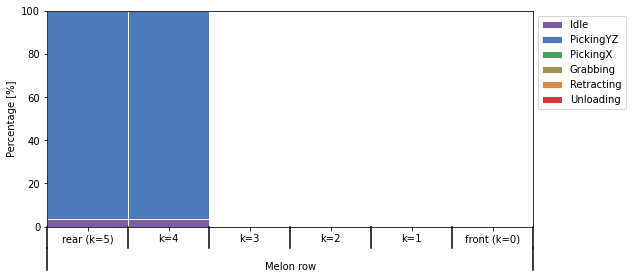

Saving 2D plot of the schedule ./plots/2dschedule.png


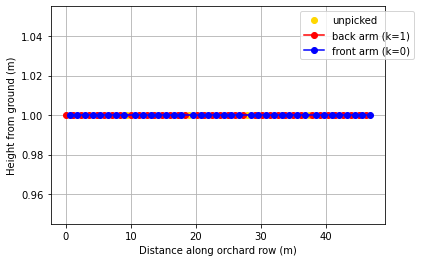

In [15]:
if __name__ == "__main__":
    # Base model
    printScen("Solving base scenario model")
    [fruit_picked_by, v_vy_cmps] = solve_melon_mip(arm, fruit, job)
    
    v_vy = v_vy_cmps / 100 # change to m/s
#     solve_melon_mip_read()
    
    total_arms = n_arm * n_row
    total_picked = np.sum(curr_j)
            
    FPE = (total_picked / numFruit)
    FPT = total_picked / (travel_l / v_vy)
    
    print()
    print('FPE:', FPE*100, '%, and FPT:', FPT, 'fruit/s')    
    print()            
    print('A total of', total_picked, 'fruits were harvested out of', numFruit)
    print('How many fruit were picked by each arm: *front* ', curr_j, ' *back*, fruit')
    print()

#     print('Sorted fruit list')
#     print(sortedFruit)
    
    # list for when there are multiple snapshots over the length of travel
    snapshot_list = list()
    snapshot_cell = list()
    
    # calculate how long each arm was working vs idle
    state_time = calcStateTime(fruit_picked_by, travel_l, v_vy, total_arms, n_row, n_arm, Td)

    # fill in snapshot object and list with current results
    snapshot = Snapshot(n_arm, n_row, horizon_l, vehicle_l, cell_l, v_max, a_max, set_algorithm, Td, v_vy, FPE, FPT, y_lim, numFruit, curr_j, sortedFruit, fruit_picked_by, state_time)
    snapshot_list.append(snapshot)
    ## continue filling if needed: PCT, state_time, fruit_picked_by, fruit_list (all lists?)
    
    horizon_indexes = getHorizonIndex(sortedFruit, q_vy, vehicle_l, horizon_l)
    print(horizon_indexes)

    ## calculate multiple R and v_vy values based on multiple slices of the current view
    # return a list of fruit densities in each cell
    d = calcDensity(q_vy, v_vy, n_row, n_arm, cell_l, cell_h, arm_reach, sortedFruit)
    # print()
    ## I wonder if calculating the max number of fruit in a bunch would help...

    ## using the fruit densities, determine the vehicle speed to set a specific R value?
    # currently, the R value would be 
    R = calcR(v_vy, len(horizon_indexes), horizon_l, vehicle_h, arm_reach)  # calculated based on columns and the horizon length

    snapshot_cell.append([d, R])

    # # combine the results based on the various snapshots taken
    results = IG_data_analysis(snapshot_list, snapshot_cell, travel_l, y_lim, set_algorithm, print_out)
    if print_out == 1:
        results.printSettings()

#     [realFPE, realFPT] = results.realFPEandFPT(sortedFruit, y_lim, v_vy)
    results.avgFPTandFPE()
    # results.avgPCT()
    # print()
    # results.plotValuesOverDistance()
    if plot_out == 1:
        results.plotTotalStatePercent()

        snapshot_schedules_2_plot = range(n_snapshots)  
        results.plot2DSchedule(snapshot_schedules_2_plot)